# Generate H5AD output 

In [1]:
# Loading the Packages

%load_ext autoreload
%autoreload 2

import os
import warnings 
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from skimage.filters import threshold_otsu, gaussian
from skimage.morphology import remove_small_objects

from starmap.obj import STARMapDataset, load_data
import starmap.analyze as anz
import starmap.viz as viz
import starmap.sc_util as su
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# test
from starmap.utilities import *
from starmap.sequencing import *
from anndata import AnnData

# test()

In [2]:
# Set path
base_path = './'
out_path = os.path.join(base_path, 'output')

expr_path = os.path.join(out_path, 'complete_cell_barcode_count.csv')
var_path = os.path.join(out_path, 'cell_barcode_names.csv')
obs_path = os.path.join(out_path, 'complete_meta.csv')

# add expression data to the AnnData object 
expr_x = np.loadtxt(expr_path, delimiter=',')
var = pd.read_csv(var_path, header=None)
var = pd.DataFrame(index=var.iloc[:,2].to_list())
obs = pd.read_csv(obs_path, index_col=0)

adata = AnnData(X=expr_x, var=var, obs=obs)

In [3]:
adata

AnnData object with n_obs × n_vars = 37067 × 2766
    obs: 'orig_index', 'sample', 'area', 'tau', 'x', 'y'

### Filtration

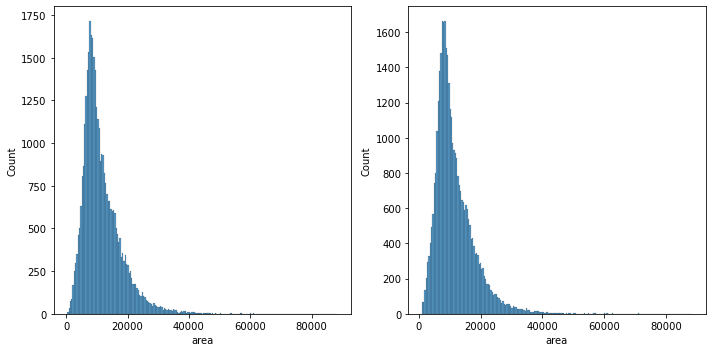

Number of cell left: 37041


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [4]:
# Calculate QC metrics
sc.pp.calculate_qc_metrics(adata, percent_top=None, inplace=True)
adata.var['max_counts'] = adata.X.max(axis=0)

# Filter cell by area 
adata = su.filter_cells_by_area(adata, min_area=1000, max_area=100000, save=False)

# Filtration 
sc.pp.filter_cells(adata, min_genes=10)
sc.pp.filter_genes(adata, min_cells=10)
# Filter gene by max counts 
adata = adata[:, adata.var['max_counts'] > 2]

sc.pp.filter_cells(adata, min_counts=68)
sc.pp.filter_cells(adata, max_counts=1500)

### Add obs, var

In [15]:
# Add new obs, var
var_path = os.path.join(out_path, '2020-11-13-var.csv')
obs_path = os.path.join(out_path, '2020-12-08-obs.csv')

var = pd.read_csv(var_path, index_col=0)
obs = pd.read_csv(obs_path, index_col=0)
obs.index = obs.index.astype(str)

adata.var = var
adata.obs = obs

In [16]:
# adata.obs['cell_type'] = adata.obs['cell_type'].astype(object)
# adata.obs.loc[adata.obs['cell_type'] == 'L4/RSC_A', 'cell_type'] = 'L4/5_RSC_A'
# adata.obs.loc[adata.obs['cell_type'] == 'L4/RSC_B', 'cell_type'] = 'L4/5_RSC_B'

In [17]:
# change dtype
adata.obs['sample'] = adata.obs['sample'].astype('category')
adata.obs['sample'] = adata.obs['sample'].cat.reorder_categories(['AD_mouse9723', 'AD_mouse9735', 'AD_mouse9494', 'AD_mouse9498'])

adata.obs['batch'] = adata.obs['batch'].astype('category')
adata.obs['batch'] = adata.obs['batch'].cat.reorder_categories(['batch_1', 'batch_2'])

adata.obs['time'] = adata.obs['time'].astype('category')
adata.obs['time'] = adata.obs['time'].cat.reorder_categories(['8_months', '13_months'])

adata.obs['group'] = adata.obs['group'].astype('category')

# top-level
top_level_order = ['Ex', 'Inhi', 'CA1', 'CA2', 'CA3', 'DG', 'Astro', 'Endo', 'Micro', 'Oligo', 'OPC', 'SMC', 'LHb']
adata.obs['top_level'] = adata.obs['top_level'].astype('category')
adata.obs['top_level'] = adata.obs['top_level'].cat.reorder_categories(top_level_order)

# sub-level
# cell_type_order = ['L2/3', 'L4/RSC_A', 'L4/RSC_B', 'L6',
#                            'Inhi_Cnr1', 'Inhi_Lamp5', 'Inhi_Pvalb', 'Inhi_Sst',
#                            'CA1', 'CA2', 'CA3', 'DG', 
#                             'Astro', 'Astro_Aqp4/Gfap', 'Astro_Gpr37l1/Cst3', 'Astro_Id4/Cst3',
#                            'Endo', 'Endo_Cldn5+', 'Endo_Esam+',
#                            'Micro', 'Micro_Gpr34', 'Micro_Cst7/Ctsb',
#                            'Oligo', 'Oligo_Cldn11', 'Oligo_Itga9', 'Oligo_Klk6', 'Oligo_Neat1/Enpp2', 'Oligo_Ntsr1', 'Oligo_Tmem88b',
#                             'OPC', 'OPC_Gpr17',
#                            'SMC', 'Peri_A', 'Peri_B', 'VLMC_A', 'VLMC_B',
#                             'LHb']

cell_type_order = ['L2/3', 'L4/5_RSC_A', 'L4/5_RSC_B', 'L6',
                           'Inhi_Cnr1', 'Inhi_Lamp5', 'Inhi_Pvalb', 'Inhi_Sst',
                           'CA1', 'CA2', 'CA3', 'DG', 
                            'Astro', 'Astro_Cst3', 'Astro_Gfap/Vim',
                           'Endo', 'Endo_Cldn5+', 'Endo_Esam+',
                           'Micro', 'Micro_Gpr34', 'Micro_Cst7/Ctsb',
                           'Oligo', 'Oligo_Cldn11', 'Oligo_Klk6',
                            'OPC', 'OPC_Gpr17',
                           'SMC', 'Peri_A', 'Peri_B', 'VLMC_A', 'VLMC_B',
                            'LHb']

adata.obs['cell_type'] = adata.obs['cell_type'].astype('category')
adata.obs['cell_type'] = adata.obs['cell_type'].cat.reorder_categories(cell_type_order)

# Save order 
adata.uns['top_level_order'] = top_level_order
adata.uns['cell_type_order'] = cell_type_order

In [18]:
# get sub-level label

cell_type_label = ['CTX-Ex1', 'CTX-Ex2', 'CTX-Ex3', 'CTX-Ex4',
                           'In1', 'In2', 'In3', 'In4',
                           'CA1', 'CA2', 'CA3', 'DG', 
                            'A1', 'A2', 'A3',
                           'E1', 'E2', 'E3',
                           'M1', 'M2', 'M3',
                           'OL1', 'OL2', 'OL3',
                            'O1', 'O2',
                           'S1', 'S2', 'S3', 'S4', 'S5',
                            'LHb']

cell_type_dict = dict(zip(cell_type_order, cell_type_label))

adata.obs['cell_type_label'] = adata.obs['cell_type'].map(cell_type_dict)
adata.uns['cell_type_label'] = cell_type_label
adata.obs['cell_type_label']

2             DG
8             A3
9             DG
11            S4
13            M3
          ...   
37057        LHb
37059    CTX-Ex2
37060        LHb
37061        In1
37062        OL1
Name: cell_type_label, Length: 33106, dtype: category
Categories (32, object): ['CTX-Ex1', 'CTX-Ex2', 'CTX-Ex3', 'CTX-Ex4', ..., 'S3', 'S4', 'S5', 'LHb']

### Normalization

In [29]:
# Normalization scaling
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

adata.raw = adata

### Scaling and Correction 

In [30]:
# Scale data to unit variance and zero mean
sc.pp.scale(adata)
adata.layers['scaled'] = adata.X

# Batch correction
sc.pp.combat(adata)
adata.layers['corrected'] = adata.X

### Get color info

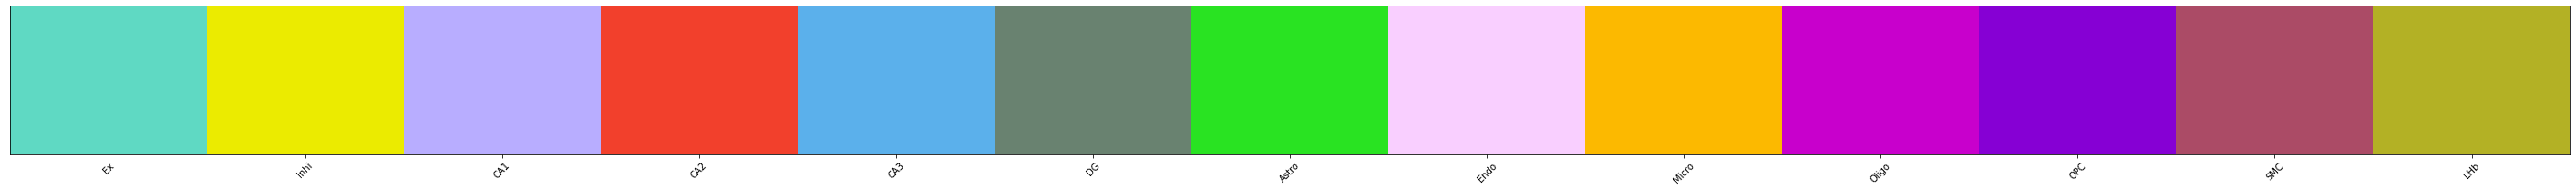

In [19]:
top_hex_dict = {'Ex': '#5fd9c3', 
                'Inhi': '#ebeb00', 
                'CA1': '#b8adff', 
                'CA2': '#f2402c', 
                'CA3': '#5bb0eb', 
                'DG': '#698270', 
                'Astro': '#29e322', 
                'Endo': '#f9cfff', 
                'Micro': '#fcb900', 
                'Oligo': '#c800cc', 
                'OPC': '#8600d4', 
                'SMC': '#ab4b66', 
                'LHb': '#b3b125'}



top_cpl = sns.color_palette(list(top_hex_dict.values()))
sns.palplot(top_cpl, size=3)
plt.xticks(range(len(top_level_order)), top_level_order, size=10, rotation=45)
plt.tight_layout()
plt.show()

adata.uns['top_rgb_dict'] = dict(zip(top_level_order, list(map(list, top_cpl))))
adata.uns['top_hex_dict'] = dict(zip(top_level_order, top_cpl.as_hex()))

In [20]:
# # top-level color dict 

# top_cpl = sns.color_palette("Set3", len(top_level_order)-1)
# top_cpl[8] = (0.4117647058823529, 0.5098039215686274, 0.4392156862745098)
# top_cpl[8], top_cpl[5] = top_cpl[5], top_cpl[8]
# # top_cpl[8] = (0.4117647058823529, 0.5098039215686274, 0.4392156862745098)
# top_cpl.insert(11, (0.7607843137254902, 0.23529411764705882, 0.6745098039215687))

# top_cmap = ListedColormap(top_cpl.as_hex())

# sns.palplot(top_cpl, size=3)
# plt.xticks(range(len(top_level_order)), top_level_order, size=10, rotation=45)
# plt.tight_layout()
# plt.show()
    
# # adata.uns['top_rgb_dict'] = dict(zip(top_level_order, top_cpl))
# # adata.uns['top_hex_dict'] = dict(zip(top_level_order, top_cpl.as_hex()))

# # adata.uns['top_rgb_dict'] = dict(zip(top_level_order, list(map(list, top_cpl))))
# # adata.uns['top_hex_dict'] = dict(zip(top_level_order, top_cpl.as_hex()))

Ex
['L2/3', 'L4/5_RSC_A', 'L4/5_RSC_B', 'L6']


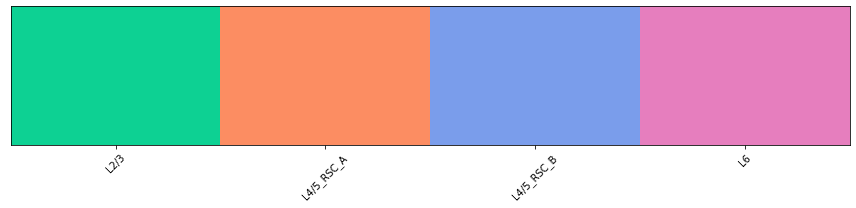

Inhi
['Inhi_Cnr1', 'Inhi_Lamp5', 'Inhi_Pvalb', 'Inhi_Sst']


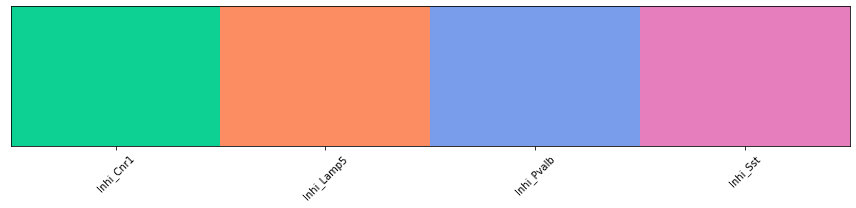

CA1
['CA1']


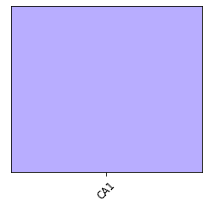

CA2
['CA2']


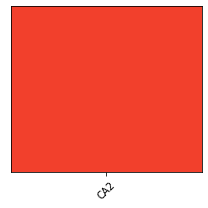

CA3
['CA3']


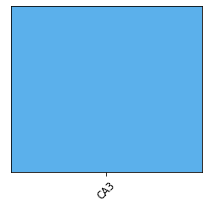

DG
['DG']


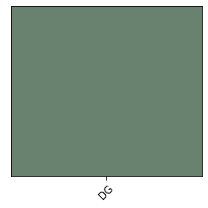

Astro
['Astro', 'Astro_Cst3', 'Astro_Gfap/Vim']


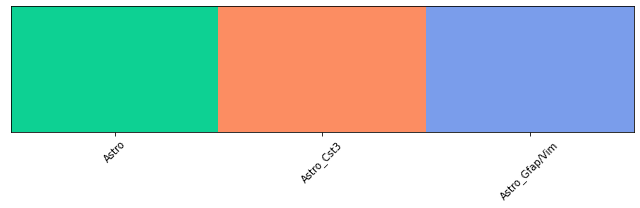

Endo
['Endo', 'Endo_Cldn5+', 'Endo_Esam+']


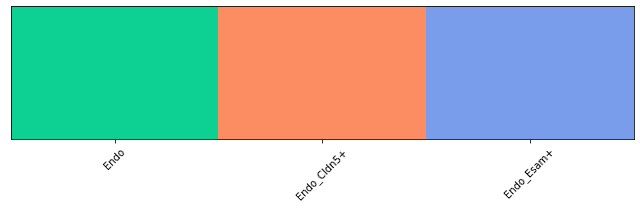

Micro
['Micro', 'Micro_Gpr34', 'Micro_Cst7/Ctsb']


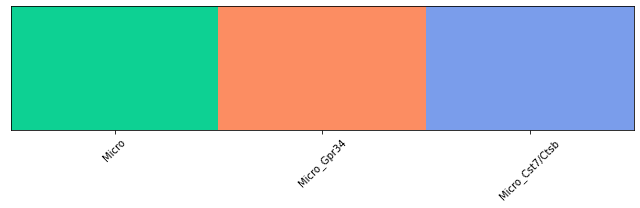

Oligo
['Oligo', 'Oligo_Cldn11', 'Oligo_Klk6']


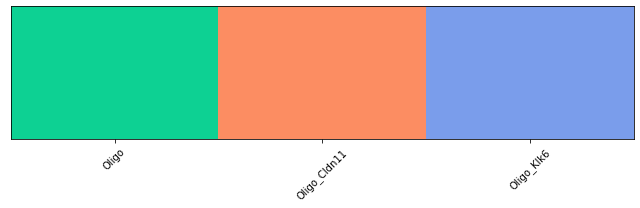

OPC
['OPC', 'OPC_Gpr17']


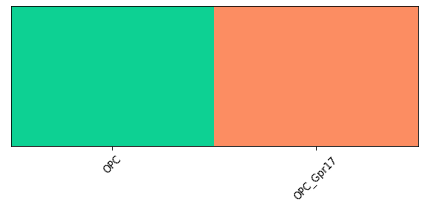

SMC
['SMC', 'Peri_A', 'Peri_B', 'VLMC_A', 'VLMC_B']


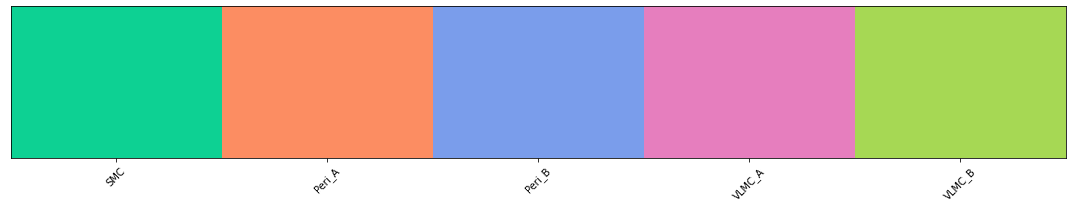

LHb
['LHb']


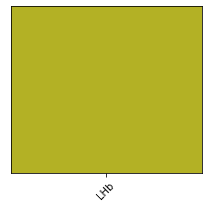

In [21]:
# sub-level color dict 
sub_color_list = ['#0dd193', '#fc8d62', '#7a9deb', '#e67ebe', '#a6d854']
sub_cpl = []

start = 0
for i, label in enumerate(top_level_order):
    print(label)
    curr_index = adata.obs.loc[adata.obs['top_level'] == label, 'cell_type'].unique().shape[0]
    curr_cat = cell_type_order[start:start + curr_index]
    start += curr_index
    
    print(curr_cat)
    n_colors = len(curr_cat)
    if n_colors > 1:
        #curr_cpl = sns.color_palette("Set2", n_colors)
        curr_cpl = sns.color_palette(sub_color_list[:n_colors])
        sub_cpl += curr_cpl
    else:
        # print('xx')
        curr_cpl = [adata.uns['top_rgb_dict'][curr_cat[0]]]
        sub_cpl += curr_cpl
    
    sns.palplot(curr_cpl, size=3)
    plt.xticks(range(n_colors), curr_cat, size=10, rotation=45)
    plt.tight_layout()
    plt.show()

sub_cpl = sns.color_palette(sub_cpl)
# adata.uns['sub_rgb_dict']  = dict(zip(cell_type_order, sub_cpl))
# adata.uns['sub_hex_dict']  = dict(zip(cell_type_order, sub_cpl.as_hex()))

adata.uns['sub_rgb_dict']  = dict(zip(cell_type_order, list(map(list, sub_cpl))))
adata.uns['sub_hex_dict']  = dict(zip(cell_type_order, sub_cpl.as_hex()))

In [22]:
# switch micro subtype color
# a = sns.color_palette("Set2", 3)
a = sns.color_palette(sub_color_list[:3])
b = a.as_hex()
# list(a[1])

adata.uns['sub_rgb_dict']['Micro_Gpr34'] = list(a[2])
adata.uns['sub_hex_dict']['Micro_Gpr34'] = b[2]
adata.uns['sub_rgb_dict']['Micro_Cst7/Ctsb'] = list(a[1])
adata.uns['sub_hex_dict']['Micro_Cst7/Ctsb'] = b[1]

adata.uns['sub_rgb_dict']['Astro_Cst3'] = list(a[2])
adata.uns['sub_hex_dict']['Astro_Cst3'] = b[2]
adata.uns['sub_rgb_dict']['Astro_Gfap/Vim'] = list(a[1])
adata.uns['sub_hex_dict']['Astro_Gfap/Vim'] = b[1]


In [23]:
sns.color_palette([adata.uns['sub_rgb_dict']['Micro_Gpr34']])

[(0.47843137254901963, 0.615686274509804, 0.9215686274509803)]

In [24]:
# add color to cell_type_label
adata.uns['label_rgb_dict']  = dict(zip(cell_type_label, list(adata.uns['sub_rgb_dict'].values())))
adata.uns['label_hex_dict']  = dict(zip(cell_type_label, list(adata.uns['sub_hex_dict'].values())))

In [25]:
adata

AnnData object with n_obs × n_vars = 33106 × 2112
    obs: 'orig_index', 'sample', 'area', 'tau', 'x', 'y', 'batch', 'time', 'group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts', 'leiden', '__is_in_cluster__', 'top_level', 'cell_type', 'region', 'cell_type_label'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'max_counts', 'n_cells', 'mean', 'std'
    uns: 'top_level_order', 'cell_type_order', 'cell_type_label', 'top_rgb_dict', 'top_hex_dict', 'sub_rgb_dict', 'sub_hex_dict', 'label_rgb_dict', 'label_hex_dict'

## Original image

In [ ]:
# Load data and store the information to uns
for sample in sorted(adata.obs['sample'].unique()):
    print(sample)
    
    current_seg_path = os.path.join(sample, 'segmentation/labeled_cells.tif')
    current_img = tifffile.imread(current_seg_path)
    
    current_plaque_path = os.path.join(sample, 'trimmed_images/plaque.tif')
    current_plaque = tifffile.imread(current_plaque_path)
    current_plaque = gaussian(current_plaque.astype(np.float), 2) > 30
    # current_plaque = remove_small_objects(current_plaque, min_size=64, connectivity=4)
    
    current_tau_path = os.path.join(sample, 'trimmed_images/tau.tif')
    current_tau = tifffile.imread(current_tau_path)
    current_tau = gaussian(current_tau.astype(np.float), 2) > 50

    current_key = f"{sample}_morph"
    adata.uns[current_key] = {}
    adata.uns[current_key]['label_img'] = current_img
    adata.uns[current_key]['plaque'] = current_plaque
    adata.uns[current_key]['tau'] = current_tau

In [ ]:
# Save
adata.write_h5ad('./output/2020-11-13-starmap-mAD-raw-org.h5ad')

## Scaled 0.3

In [26]:
# Load data and store the information to uns
for sample in sorted(adata.obs['sample'].unique()):
    print(sample)
    
    # Segmentation
    current_seg_path = os.path.join(sample, 'segmentation/scaled/labeled_cells.tif')
    current_img = tifffile.imread(current_seg_path)
    
    # Plaque
    current_plaque_path = os.path.join(sample, 'segmentation/scaled/plaque.tif')
    current_plaque = tifffile.imread(current_plaque_path)
    current_plaque = gaussian(current_plaque.astype(np.float), 2) > 30
    # current_plaque = remove_small_objects(current_plaque, min_size=64, connectivity=4)
    
    # Tau
    current_tau_path = os.path.join(sample, 'segmentation/scaled/tau.tif')
    current_tau = tifffile.imread(current_tau_path)
    if sample != 'AD_mouse9735':
        current_tau = gaussian(current_tau.astype(np.float), 2) > 50
    else:
        current_tau = gaussian(current_tau.astype(np.float), 2) > 100
        
    # Region
    current_region_path = os.path.join(sample, 'segmentation/scaled/bill-labels.tif')
    current_region_img = tifffile.imread(current_region_path)

    # Morph
    current_key = f"{sample}_morph"
    adata.uns[current_key] = {}
    adata.uns[current_key]['label_img'] = current_img
    adata.uns[current_key]['plaque'] = current_plaque
    adata.uns[current_key]['tau'] = current_tau
    adata.uns[current_key]['region'] = current_region_img

AD_mouse9494
AD_mouse9498
AD_mouse9723
AD_mouse9735


In [27]:
# Add region info
for sample in sorted(adata.obs['sample'].unique()):
    
    current_key = f"{sample}_morph"
    current_region_img = adata.uns[current_key]['region']
    
    current_index = adata.obs['sample'] == sample
    sdata = adata[current_index, :]

    current_col = sdata.obs['x'].values
    current_row = sdata.obs['y'].values
    current_region_value = current_region_img[current_row, current_col]
    adata.obs.loc[current_index, 'region'] = current_region_value
    
adata.obs['region'] = adata.obs['region'].astype(int)
adata.obs['region'] = adata.obs['region'].map({1:'Cortex', 2:'White Matter', 3:'Hippocampus'})
adata.obs['region'] = adata.obs['region'].astype('category')
adata.obs['region'] = adata.obs['region'].cat.reorder_categories(['Cortex', 'White Matter', 'Hippocampus'])

In [42]:
# # Scale x and y 
# adata.obs['x'] = adata.obs['x'] * .3
# adata.obs['x'] = adata.obs['x'].astype(int)
# adata.obs['y'] = adata.obs['y'] * .3
# adata.obs['y'] = adata.obs['y'].astype(int)

In [31]:
# Save
adata.write_h5ad('./output/2020-12-27-starmap-mAD-scaled.h5ad')

# Test

In [ ]:
adata = sc.read_h5ad('./output/2020-11-27-starmap-mAD-raw-scaled.h5ad')
adata

In [ ]:
a = sns.color_palette(['#e6e600'])
b = a.as_hex()
print(a, b)

In [ ]:
# Change Inhi 
adata.uns['top_rgb_dict']['Inhi'] = np.array(a[0])
adata.uns['top_hex_dict']['Inhi'] = list(b)[0]

In [ ]:
a = sns.color_palette(['#ff6464'])
b = a.as_hex()
print(a, b)

In [ ]:
# Change Lhb 
adata.uns['top_rgb_dict']['LHb'] = np.array(a[0])
adata.uns['top_hex_dict']['LHb'] = list(b)[0]

adata.uns['sub_rgb_dict']['LHb'] = np.array(a[0])
adata.uns['sub_hex_dict']['LHb'] = list(b)[0]


In [ ]:
adata.uns['top_rgb_dict']

In [ ]:
# Save
adata.write_h5ad('./output/2020-11-28-starmap-mAD-scaled.h5ad')

In [ ]:
# Save obs
adata.obs.to_csv('./output/2020-11-21-obs.csv')

### add region info

In [ ]:
# Load data and store the information to uns
for sample in sorted(adata.obs['sample'].unique()):
    
    current_region_path = os.path.join(sample, 'segmentation/scaled/region-labels.tif')
    current_img = tifffile.imread(current_region_path)
    
    current_index = adata.obs['sample'] == sample
    sdata = adata[current_index, :]

    print(sample, current_img.shape, sdata.obs['x'].max(), sdata.obs['y'].max())
    current_col = sdata.obs['x'].values
    current_row = sdata.obs['y'].values
    current_region_value = current_img[current_row, current_col]
    adata.obs.loc[current_index, 'region'] = current_region_value
    
adata.obs['region'] = adata.obs['region'].astype(int)
adata.obs['region'] = adata.obs['region'].map({1:'Cortex', 2:'White Matter', 3:'Hippocampus'})
adata.obs['region'] = adata.obs['region'].astype('category')
adata.obs['region'] = adata.obs['region'].cat.reorder_categories(['Cortex', 'White Matter', 'Hippocampus'])

In [ ]:
adata.obs['region']

In [ ]:
# Restore convex hull and top-level info
for sample in sorted(adata.obs['sample'].unique()):
    print(sample)
    
    current_key = f"{sample}_morph"
    adata.uns[current_key]['qhulls'], adata.uns[current_key]['coords'], adata.uns[current_key]['centroids'] = su.get_qhulls(adata.uns[current_key]['label_img'])
    
    current_index = adata.obs['sample'] == sample
    adata.uns[current_key]['good_cells'] = adata.obs.loc[current_index, 'orig_index'].astype(int).values
    adata.uns[current_key]['colors'] = adata.obs.loc[current_index, 'top_level'].cat.codes.values
    
    # add tau positive info
    tau_threshold = 30
    adata.uns[current_key]['tau_index'] = (adata.obs['tau'] > tau_threshold) & (current_index)
    

In [ ]:
# group spatial cell type map 

plot_type = 'region'
# plot_list = ['Ex', 'Inhi']
# plot_list = ['CA1', 'CA2', 'CA3', 'DG', 'LHb']
# plot_list = ['Micro', 'Astro']
# plot_list = ['Endo', 'SMC']
# plot_list = ['Oligo', 'OPC']
plot_list = ['White Matter']
# plot_list = ['Micro_Cst7/Ctsb', 'Astro_Gfap/Vim']
# plot_list = ['Astro_Gfap/Vim', 'Oligo_Klk6']
# plot_list = ['Astro_Gfap/Vim', 'Oligo_Cldn11']

curr_cells = adata.obs[plot_type].isin(plot_list)
sdata = adata[curr_cells, :]
# sdata
sdata.obs[plot_type] = sdata.obs[plot_type].cat.reorder_categories(plot_list)

if plot_list[0] in ['Micro_Cst7/Ctsb', 'Astro_Gfap/Vim']:
    curr_cpl = ['#fc8d62', '#1ec700']
    curr_cpl = sns.color_palette(curr_cpl)
else:
    curr_cpl = sns.color_palette('Set1', len(plot_list)+1)
    curr_cpl.pop(0)
    
curr_cmap = ListedColormap(curr_cpl.as_hex())
sns.palplot(curr_cpl, size=3)
plt.xticks(range(len(plot_list)), plot_list, size=10, rotation=45)
plt.tight_layout()
# plt.savefig(f'./figures/color_legend.png')
plt.show()

# Spatial cell type 
for sample in sorted(sdata.obs['sample'].unique()):
    current_key = f"{sample}_morph"
    current_index = sdata.obs['sample'] == sample
    # change to new color 
    sdata.uns[current_key]['colors'] = sdata.obs.loc[current_index, plot_type].cat.codes.values
    sdata.uns[current_key]['good_cells'] = sdata.obs.loc[current_index, 'orig_index'].astype(int).values
    
#     if sample in plot_sample:
    print(sample)
    su.plot_poly_cells_cluster_by_sample(sdata, sample, curr_cmap, show_plaque=True, show_tau=True,
                                        figscale=30, width=10, height=10, save=True, show=False)

In [ ]:
adata.obs

In [ ]:
adata.X

### 2021-06-02

In [3]:
adata = sc.read_h5ad('./output/2021-04-22-starmap-mAD-raw.h5ad')
adata

AnnData object with n_obs × n_vars = 33106 × 2766
    obs: 'orig_index', 'sample', 'area', 'tau', 'x', 'y', 'batch', 'time', 'group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts', 'leiden', '__is_in_cluster__', 'top_level', 'cell_type', 'region', 'cell_type_label'
    var: 'max_counts', 'highly_variable'
    uns: 'AD_mouse9494_morph', 'AD_mouse9498_morph', 'AD_mouse9723_morph', 'AD_mouse9735_morph', 'cell_type_label', 'cell_type_order', 'label_hex_dict', 'label_rgb_dict', 'sub_hex_dict', 'sub_rgb_dict', 'top_hex_dict', 'top_level_order', 'top_rgb_dict'

In [4]:
# modify var dataframe 
var_df = pd.read_csv('./output/2021-06-02-var-bk.csv')
adata.var['detected'] = var_df['highly_variable'].values
adata.var = adata.var.drop(labels='highly_variable', axis=1)
adata.var

max_counts  detected
A2M           4.0      True
AAGAB         3.0      True
AAK1          3.0      True
ABCA2         2.0     False
ABCA7         2.0     False
...           ...       ...
ZHX1          5.0      True
ZIC1          2.0     False
ZIM1          2.0     False
ZMYM1         3.0      True
ZMYM2         7.0      True

[2766 rows x 2 columns]

In [5]:
# check obs
adata.obs['cell_type_label'].cat.categories
adata.obs['sample'] = adata.obs['sample'].cat.reorder_categories(['AD_mouse9735', 'AD_mouse9723', 'AD_mouse9498', 'AD_mouse9494'])

In [6]:
# check uns
print(adata.uns['AD_mouse9494_morph'].keys())

dict_keys(['label_img', 'plaque', 'tau'])


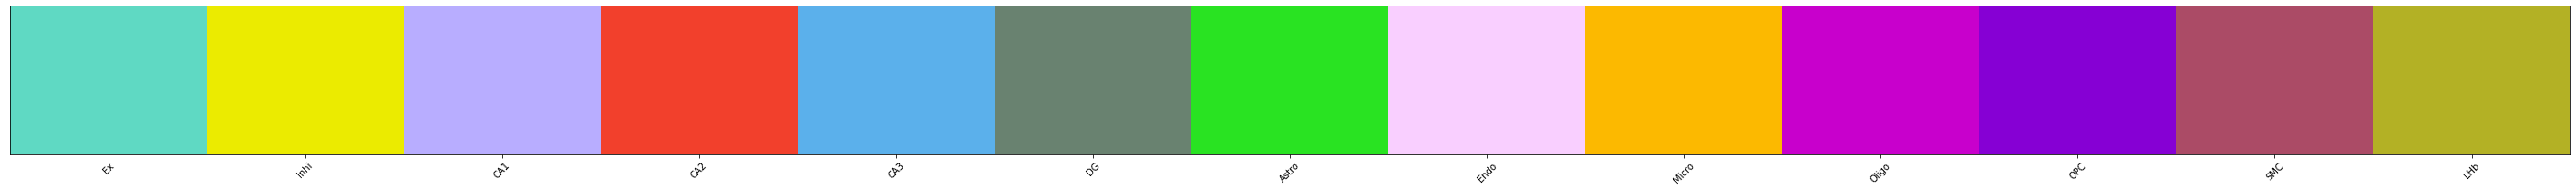

In [7]:
# check color legend (top-level)
top_cpl = []
for i in adata.uns['top_level_order']:
    top_cpl.append(adata.uns['top_rgb_dict'][i])

top_cpl = sns.color_palette(top_cpl)
top_cmap = ListedColormap(top_cpl.as_hex())
sns.palplot(top_cpl, size=3)
plt.xticks(range(len(adata.uns['top_level_order'])), adata.uns['top_level_order'], size=10, rotation=45)
plt.tight_layout()
plt.show()

In [8]:
# Top-level subset 
cdata = adata[:, adata.var['detected']]

# Normalization scaling
sc.pp.normalize_total(cdata)
sc.pp.log1p(cdata)

cdata.layers['norm'] = cdata.X
cdata.raw = cdata

# Scale data to unit variance and zero mean
sc.pp.scale(cdata)
cdata.layers['scaled'] = cdata.X

# Batch correction
sc.pp.combat(cdata)
cdata.layers['corrected'] = cdata.X

#### Inhi

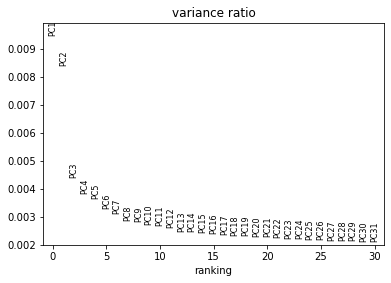

In [9]:
# cluster inhibitory neuron
# Subset
sub_id = 'Inhi'
curr_cells = cdata.obs['top_level'] == sub_id
sdata = cdata[curr_cells, :]

# Run PCA
sc.tl.pca(sdata, svd_solver='arpack')

# Plot explained variance 
sc.pl.pca_variance_ratio(sdata, log=False)

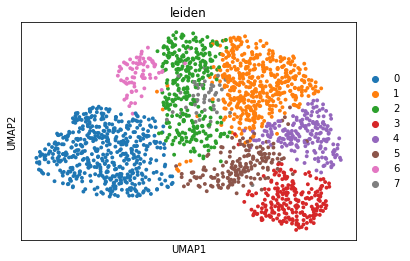

In [10]:
# Computing the neighborhood graph
n_neighbors = 30
n_pcs = 15
cluster_resolution = .9

sc.pp.neighbors(sdata, n_neighbors=n_neighbors, n_pcs=n_pcs)

# Run UMAP
sc.tl.umap(sdata)

# Run leiden
sc.tl.leiden(sdata, resolution=cluster_resolution)
sc.pl.umap(sdata, color='leiden')

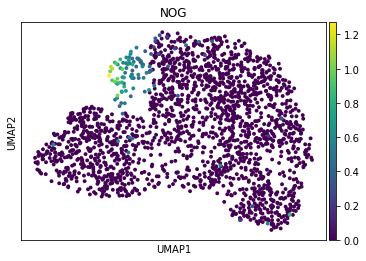

In [11]:
sc.pl.umap(sdata, color='NOG')

In [12]:
# Find gene markers for each cluster
sc.tl.rank_genes_groups(sdata, 'leiden', method='wilcoxon')

# Print markers 
markers = []
temp = pd.DataFrame(sdata.uns['rank_genes_groups']['names']).head(5)
for i in range(temp.shape[1]):
    curr_col = temp.iloc[:, i].to_list()
    markers = markers + curr_col
    print(i, curr_col)

0 ['SST', 'ELFN1', 'SATB1', 'CRHBP', 'RELN']
1 ['PVALB', 'CPLX1', 'ERBB4', 'INPP5J', 'ATP1A3']
2 ['SLC32A1', 'PVALB', 'CPLX1', 'ATP1A3', 'NEFH']
3 ['CNR1', 'CPLX2', 'CXCL14', 'KCTD12', 'CADPS2']
4 ['LAMP5', 'SLC6A1', 'GABBR2', 'DLX6OS1', 'MPDZ']
5 ['VIP', 'CPLX2', 'CNR1', 'HAP1', 'TAC2']
6 ['NOG', 'PVALB', 'CPLX1', 'GABRA1', 'ATP1A3']
7 ['RPP25', 'PVALB', 'CPLX1', 'SNAP25', 'DNM1']


In [13]:
# assign cell type 
transfer_dict = {}
cell_type_list = ['Sst', 'Pvalb', 'Pvalb', 'Cnr1',
                 'Lamp5', 'Vip', 'Pvalb_Nog', 'Pvalb']

for i in sorted(sdata.obs['leiden'].unique()):
    transfer_dict[i] = cell_type_list[int(i)]

In [14]:
# Assign cell type to sdata
sdata.obs['cell_type'] = sdata.obs['leiden'].values
sdata.obs = sdata.obs.replace({'cell_type': transfer_dict})

# Sort category
cell_type_list = sorted(list(set(cell_type_list)))
sdata.obs['cell_type'] = sdata.obs['cell_type'].astype('category')
sdata.obs['cell_type'].cat.reorder_categories(cell_type_list, inplace=True)

In [15]:
# assign cell type label  
transfer_dict = {}

for i, current_type in enumerate(cell_type_list):
    transfer_dict[current_type] = f'In{i+1}'

In [16]:
# Assign cell type label to sdata
sdata.obs['cell_type_label'] = sdata.obs['cell_type'].values
sdata.obs = sdata.obs.replace({'cell_type_label': transfer_dict})

# Sort category
cell_type_label_list = sorted(list(transfer_dict.values()))
sdata.obs['cell_type_label'] = sdata.obs['cell_type_label'].astype('category')
sdata.obs['cell_type_label'].cat.reorder_categories(cell_type_label_list, inplace=True)

In [17]:
# Map to original obj
adata.obs['cell_type'] = adata.obs['cell_type'].astype(object)
adata.obs['cell_type_label'] = adata.obs['cell_type_label'].astype(object)

adata.obs.loc[sdata.obs.index, 'cell_type'] = sdata.obs['cell_type'].values
adata.obs.loc[sdata.obs.index, 'cell_type_label'] = sdata.obs['cell_type_label'].values
adata.obs['cell_type'].unique()

array(['DG', 'Astro_Gfap/Vim', 'VLMC_A', 'Micro_Cst7/Ctsb', 'Endo',
       'Pvalb', 'L4/5_RSC_A', 'Oligo', 'Astro', 'Oligo_Cldn11',
       'Micro_Gpr34', 'Endo_Cldn5+', 'L4/5_RSC_B', 'L6', 'CA3', 'L2/3',
       'Micro', 'OPC_Gpr17', 'Astro_Cst3', 'Peri_A', 'Cnr1', 'Peri_B',
       'Endo_Esam+', 'Oligo_Klk6', 'Sst', 'OPC', 'Vip', 'CA2', 'CA1',
       'Lamp5', 'Pvalb_Nog', 'SMC', 'LHb', 'VLMC_B'], dtype=object)

In [24]:
sorted(sdata.obs['cell_type'].unique())
# adata.obs.to_csv('./output/2021-06-04-obs.csv')

['Cnr1', 'Lamp5', 'Pvalb', 'Pvalb_Nog', 'Sst', 'Vip']

#### DG

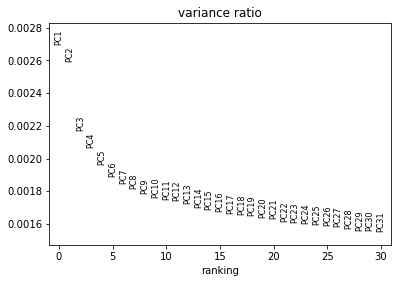

In [137]:
# cluster inhibitory neuron
# Subset
sub_id = 'DG'
curr_cells = cdata.obs['top_level'] == sub_id
sdata = cdata[curr_cells, :]

# Run PCA
sc.tl.pca(sdata, svd_solver='arpack')

# Plot explained variance 
sc.pl.pca_variance_ratio(sdata, log=False)

In [142]:
sdata.obs['sample'] = sdata.obs['sample'].cat.reorder_categories(['AD_mouse9735', 'AD_mouse9723', 'AD_mouse9498', 'AD_mouse9494'])

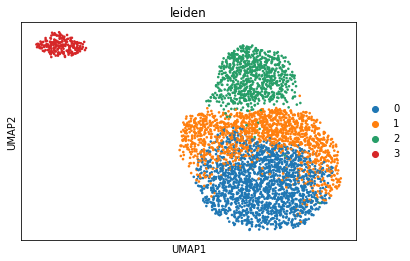

In [150]:
# Computing the neighborhood graph
n_neighbors = 30
n_pcs = 7
cluster_resolution = .3

sc.pp.neighbors(sdata, n_neighbors=n_neighbors, n_pcs=n_pcs)

# Run UMAP
sc.tl.umap(sdata)

# Run leiden
sc.tl.leiden(sdata, resolution=cluster_resolution)
sc.pl.umap(sdata, color='leiden')

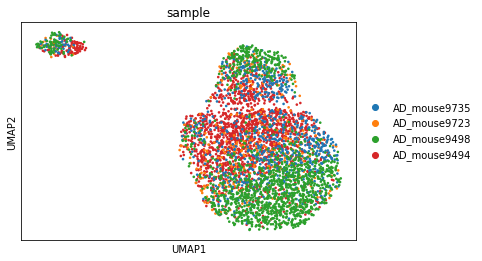

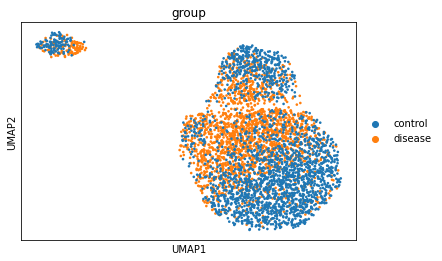

In [163]:
sc.pl.umap(sdata, color='sample')
sc.pl.umap(sdata, color='group')

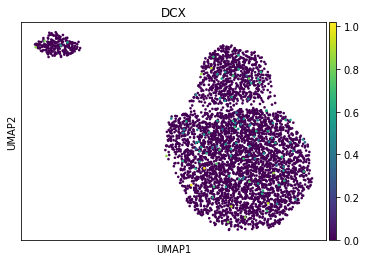

In [164]:
sc.pl.umap(sdata, color='DCX')

In [152]:
# Find gene markers for each cluster
sc.tl.rank_genes_groups(sdata, 'leiden', method='wilcoxon')

# Print markers 
markers = []
temp = pd.DataFrame(sdata.uns['rank_genes_groups']['names']).head(5)
for i in range(temp.shape[1]):
    curr_col = temp.iloc[:, i].to_list()
    markers = markers + curr_col
    print(i, curr_col)

0 ['NRGN', 'CALM1', 'ATP1A3', 'FSTL4', 'NCDN']
1 ['NR3C2', 'GNA14', 'PROX1', 'PLEKHA1', 'SLC44A5']
2 ['LCT', 'NRP1', 'CACNA1E', 'SYNGAP1', 'FEZ1']
3 ['C1QL2', 'TSPAN5', 'ATP2B3', 'RASGRP1', 'CDK5R1']


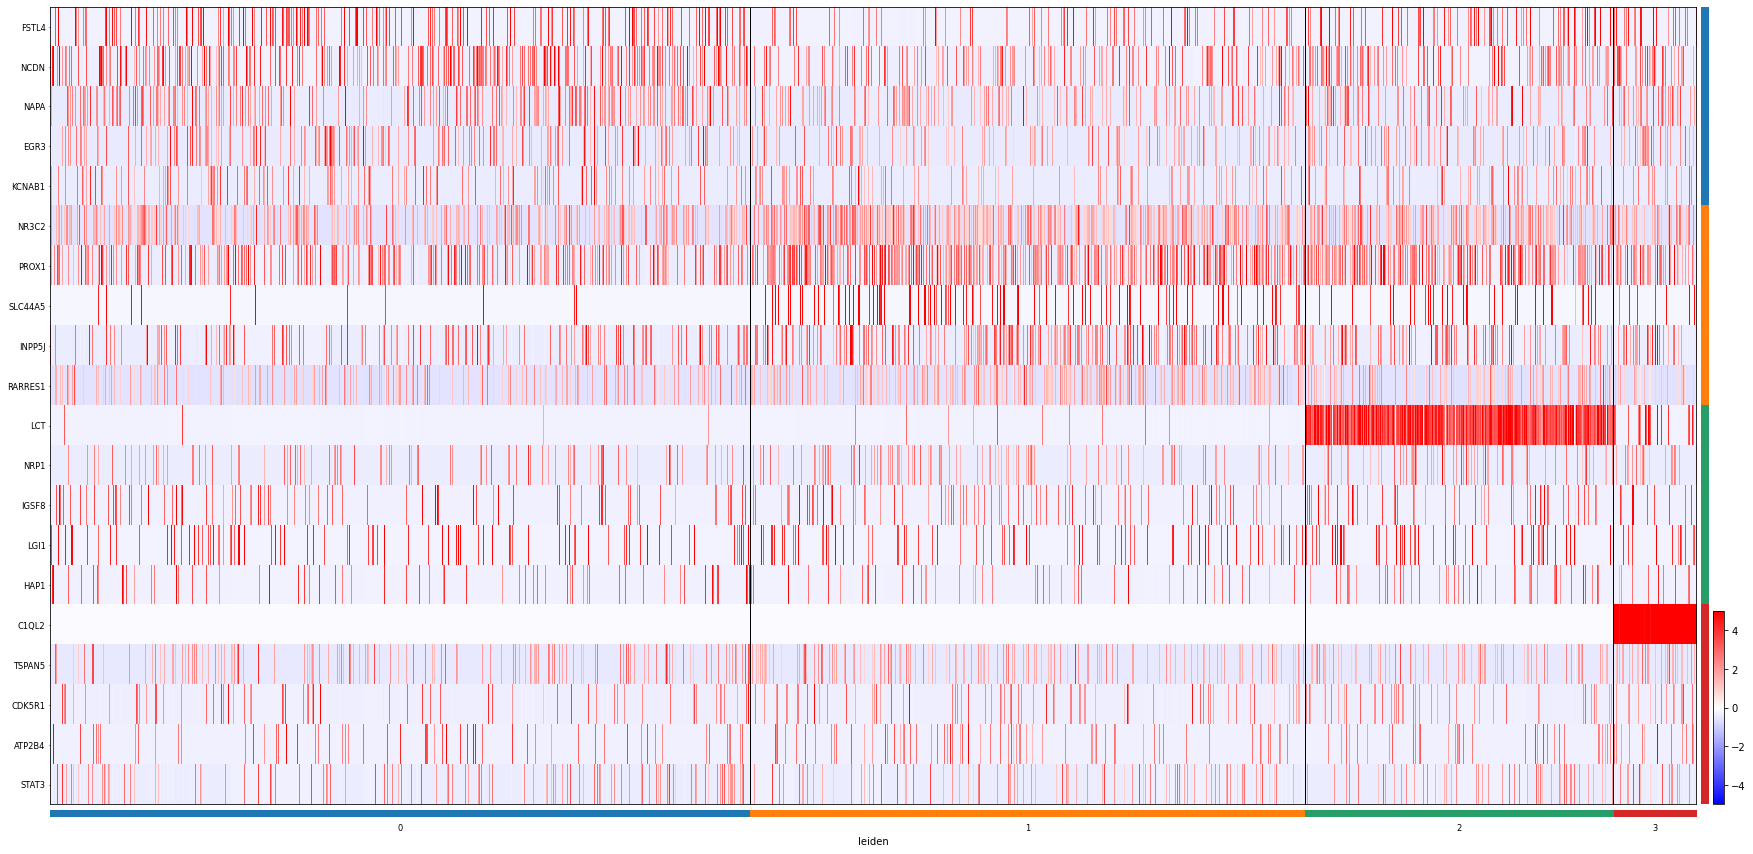

In [153]:
# Plot z-score heatmap
sc.pl.rank_genes_groups_heatmap(sdata, n_genes=5, groupby='leiden', min_logfoldchange=.5, use_raw=False, swap_axes=True, 
                                vmin=-5, vmax=5, cmap='bwr', show_gene_labels=True,
                                dendrogram=False, figsize=(30, 15))

In [156]:
# Restore convex hull and top-level info
for sample in sorted(sdata.obs['sample'].unique()):
    print(sample)
    
    current_key = f"{sample}_morph"
    sdata.uns[current_key]['qhulls'], sdata.uns[current_key]['coords'], sdata.uns[current_key]['centroids'] = su.get_qhulls(sdata.uns[current_key]['label_img'])
    
#     current_index = adata.obs['sample'] == sample
#     sdata.uns[current_key]['good_cells'] = sdata.obs.loc[current_index, 'orig_index'].astype(int).values
#     sdata.uns[current_key]['colors'] = sdata.obs.loc[current_index, 'top_level'].cat.codes.values
    
    # add tau positive info
    # tau_threshold = 30
    # adata.uns[current_key]['tau_index'] = (adata.obs['tau'] > tau_threshold) & (current_index)
    

AD_mouse9494
Geting ConvexHull...
Used 10743 / 10743
AD_mouse9498
Geting ConvexHull...
Used 8239 / 8239
AD_mouse9723
Geting ConvexHull...
Used 9189 / 9189
AD_mouse9735
Geting ConvexHull...
Used 8896 / 8896


In [157]:
# Check cluster spatial pattern 
for sample in sorted(sdata.obs['sample'].unique()):
    print(sample)
    current_key = f"{sample}_morph"

    current_index = sdata.obs['sample'] == sample
    sdata.uns[current_key]['good_cells'] = sdata.obs.loc[current_index, 'orig_index'].astype(int).values
    sdata.uns[current_key]['colors'] = sdata.obs.loc[current_index, 'leiden'].astype(int).values

AD_mouse9494
AD_mouse9498
AD_mouse9723
AD_mouse9735


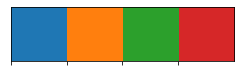

In [161]:
# Get colormap 
n_clusters = sdata.obs['leiden'].unique().shape[0]
cluster_pl = sns.color_palette('tab10', n_clusters)
sns.palplot(cluster_pl)
cluster_cmap = ListedColormap(cluster_pl)

AD_mouse9494


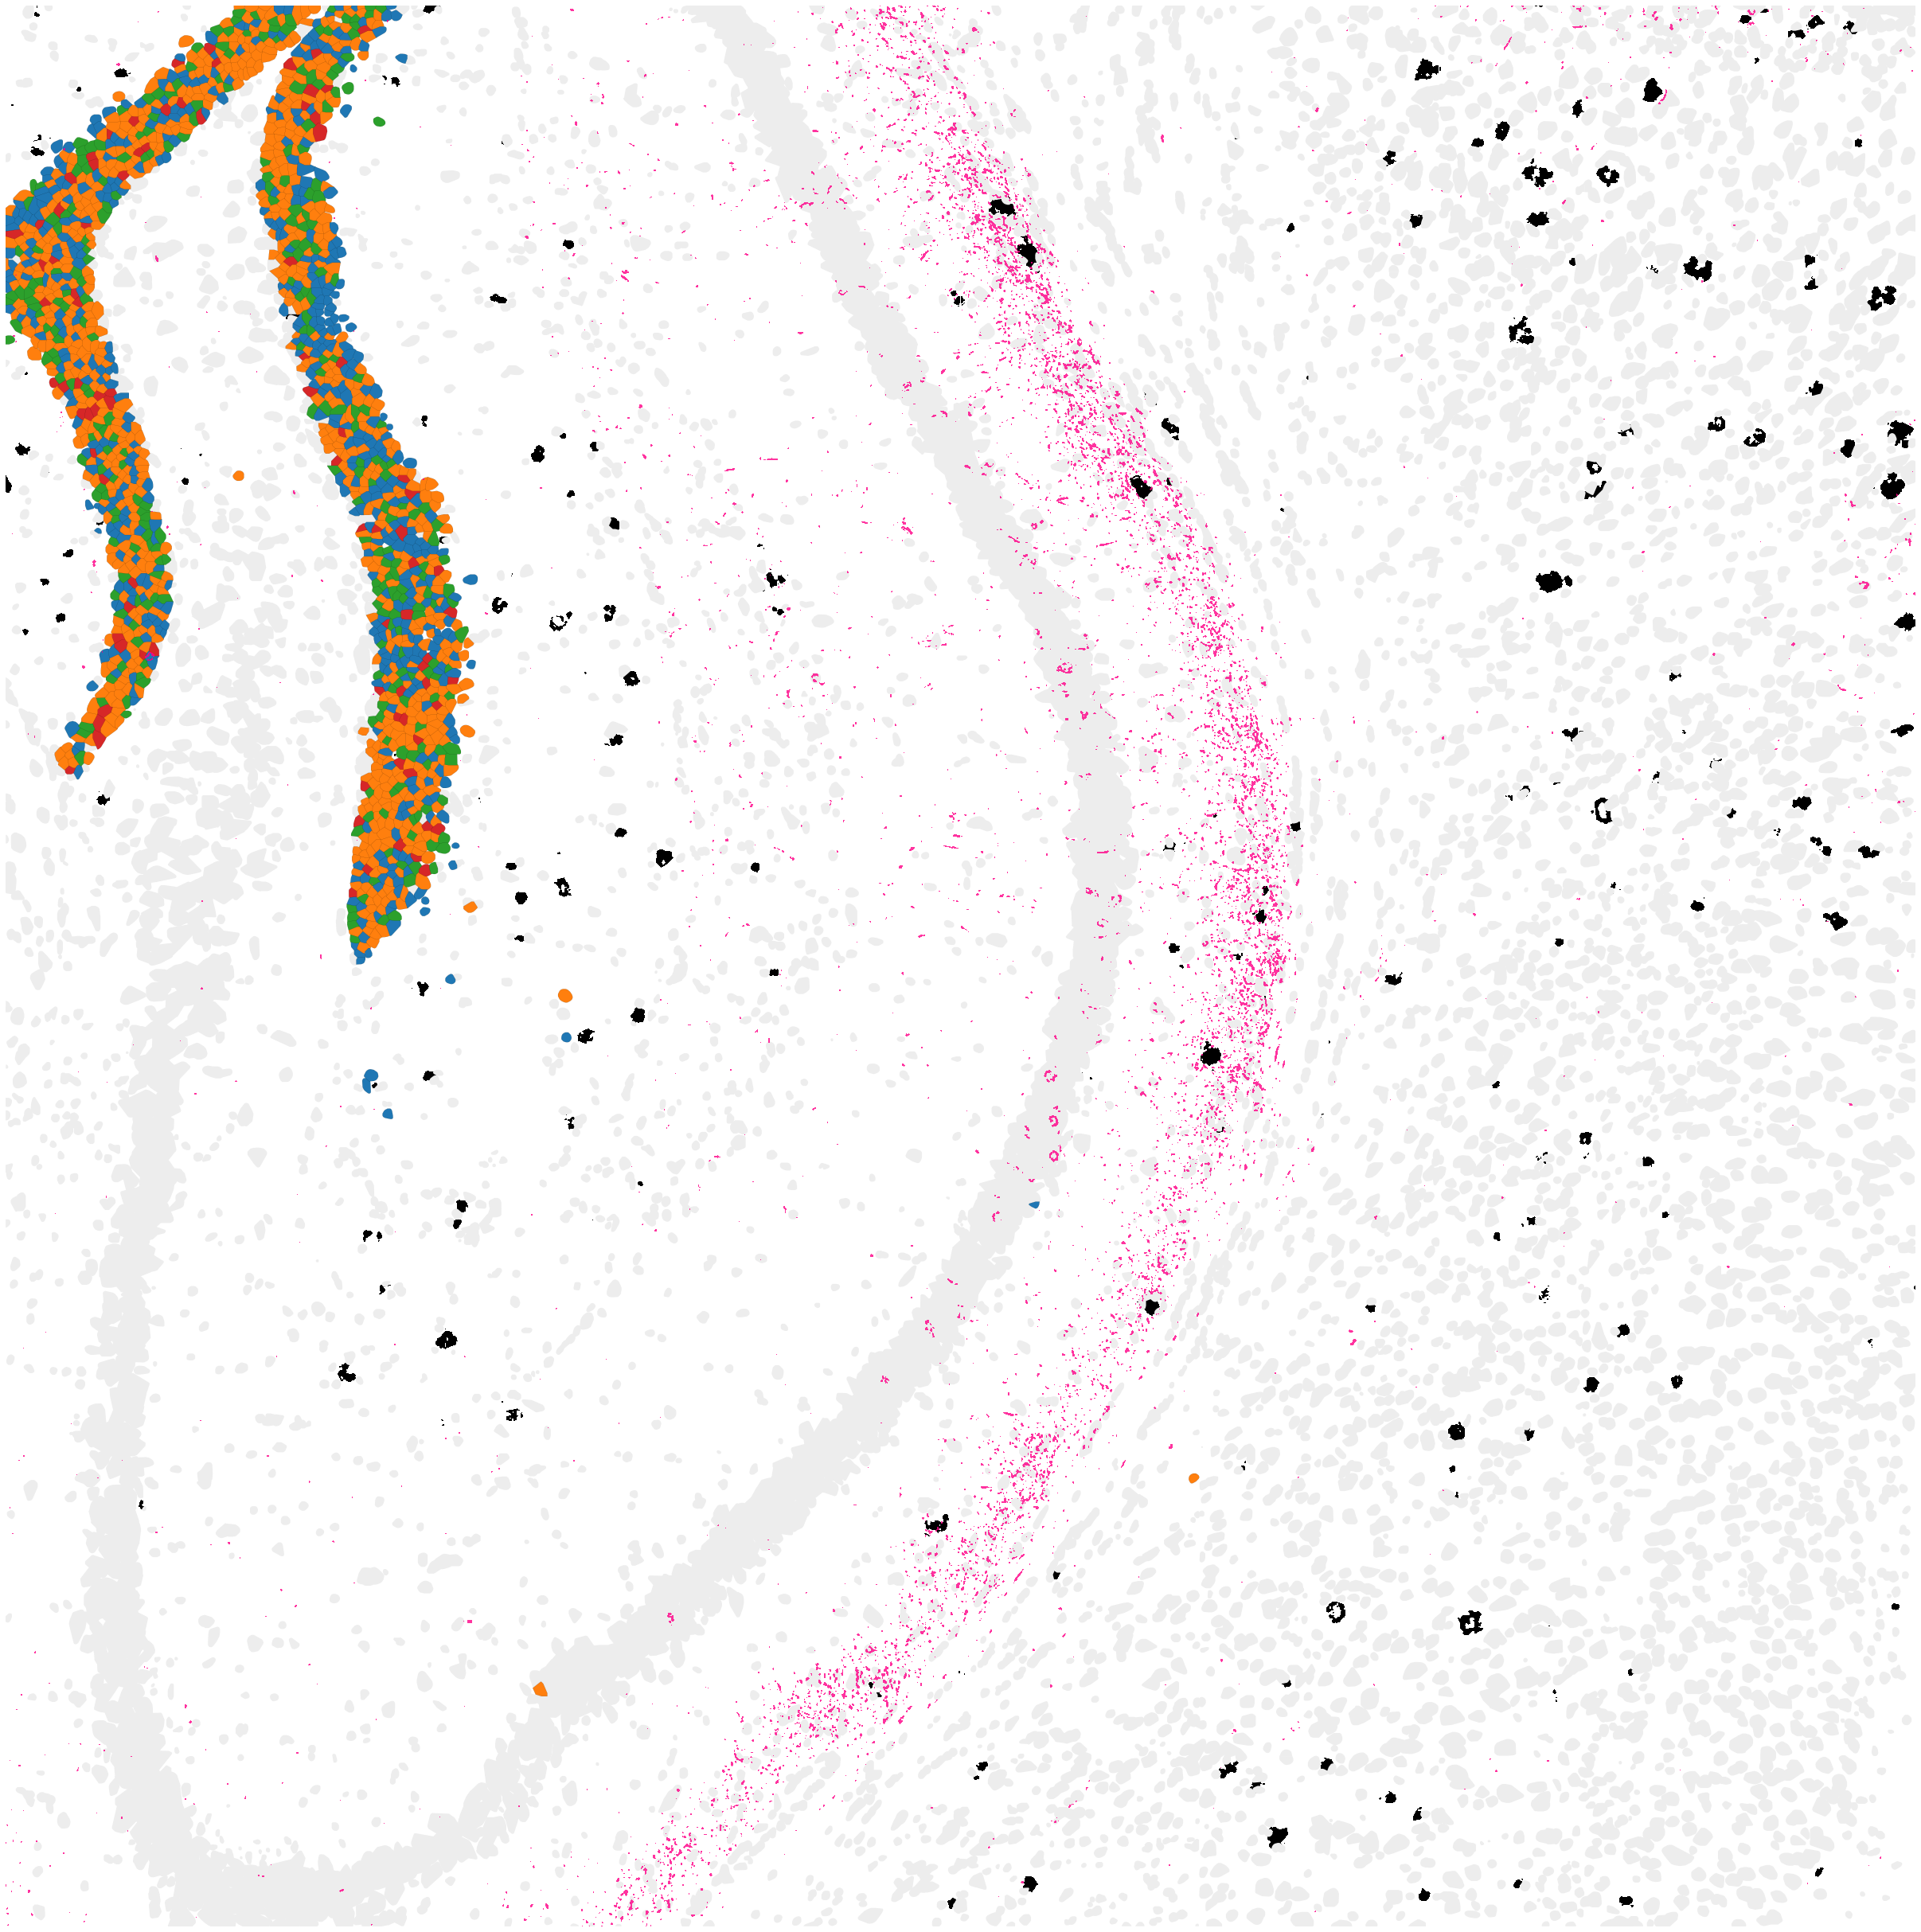

AD_mouse9498


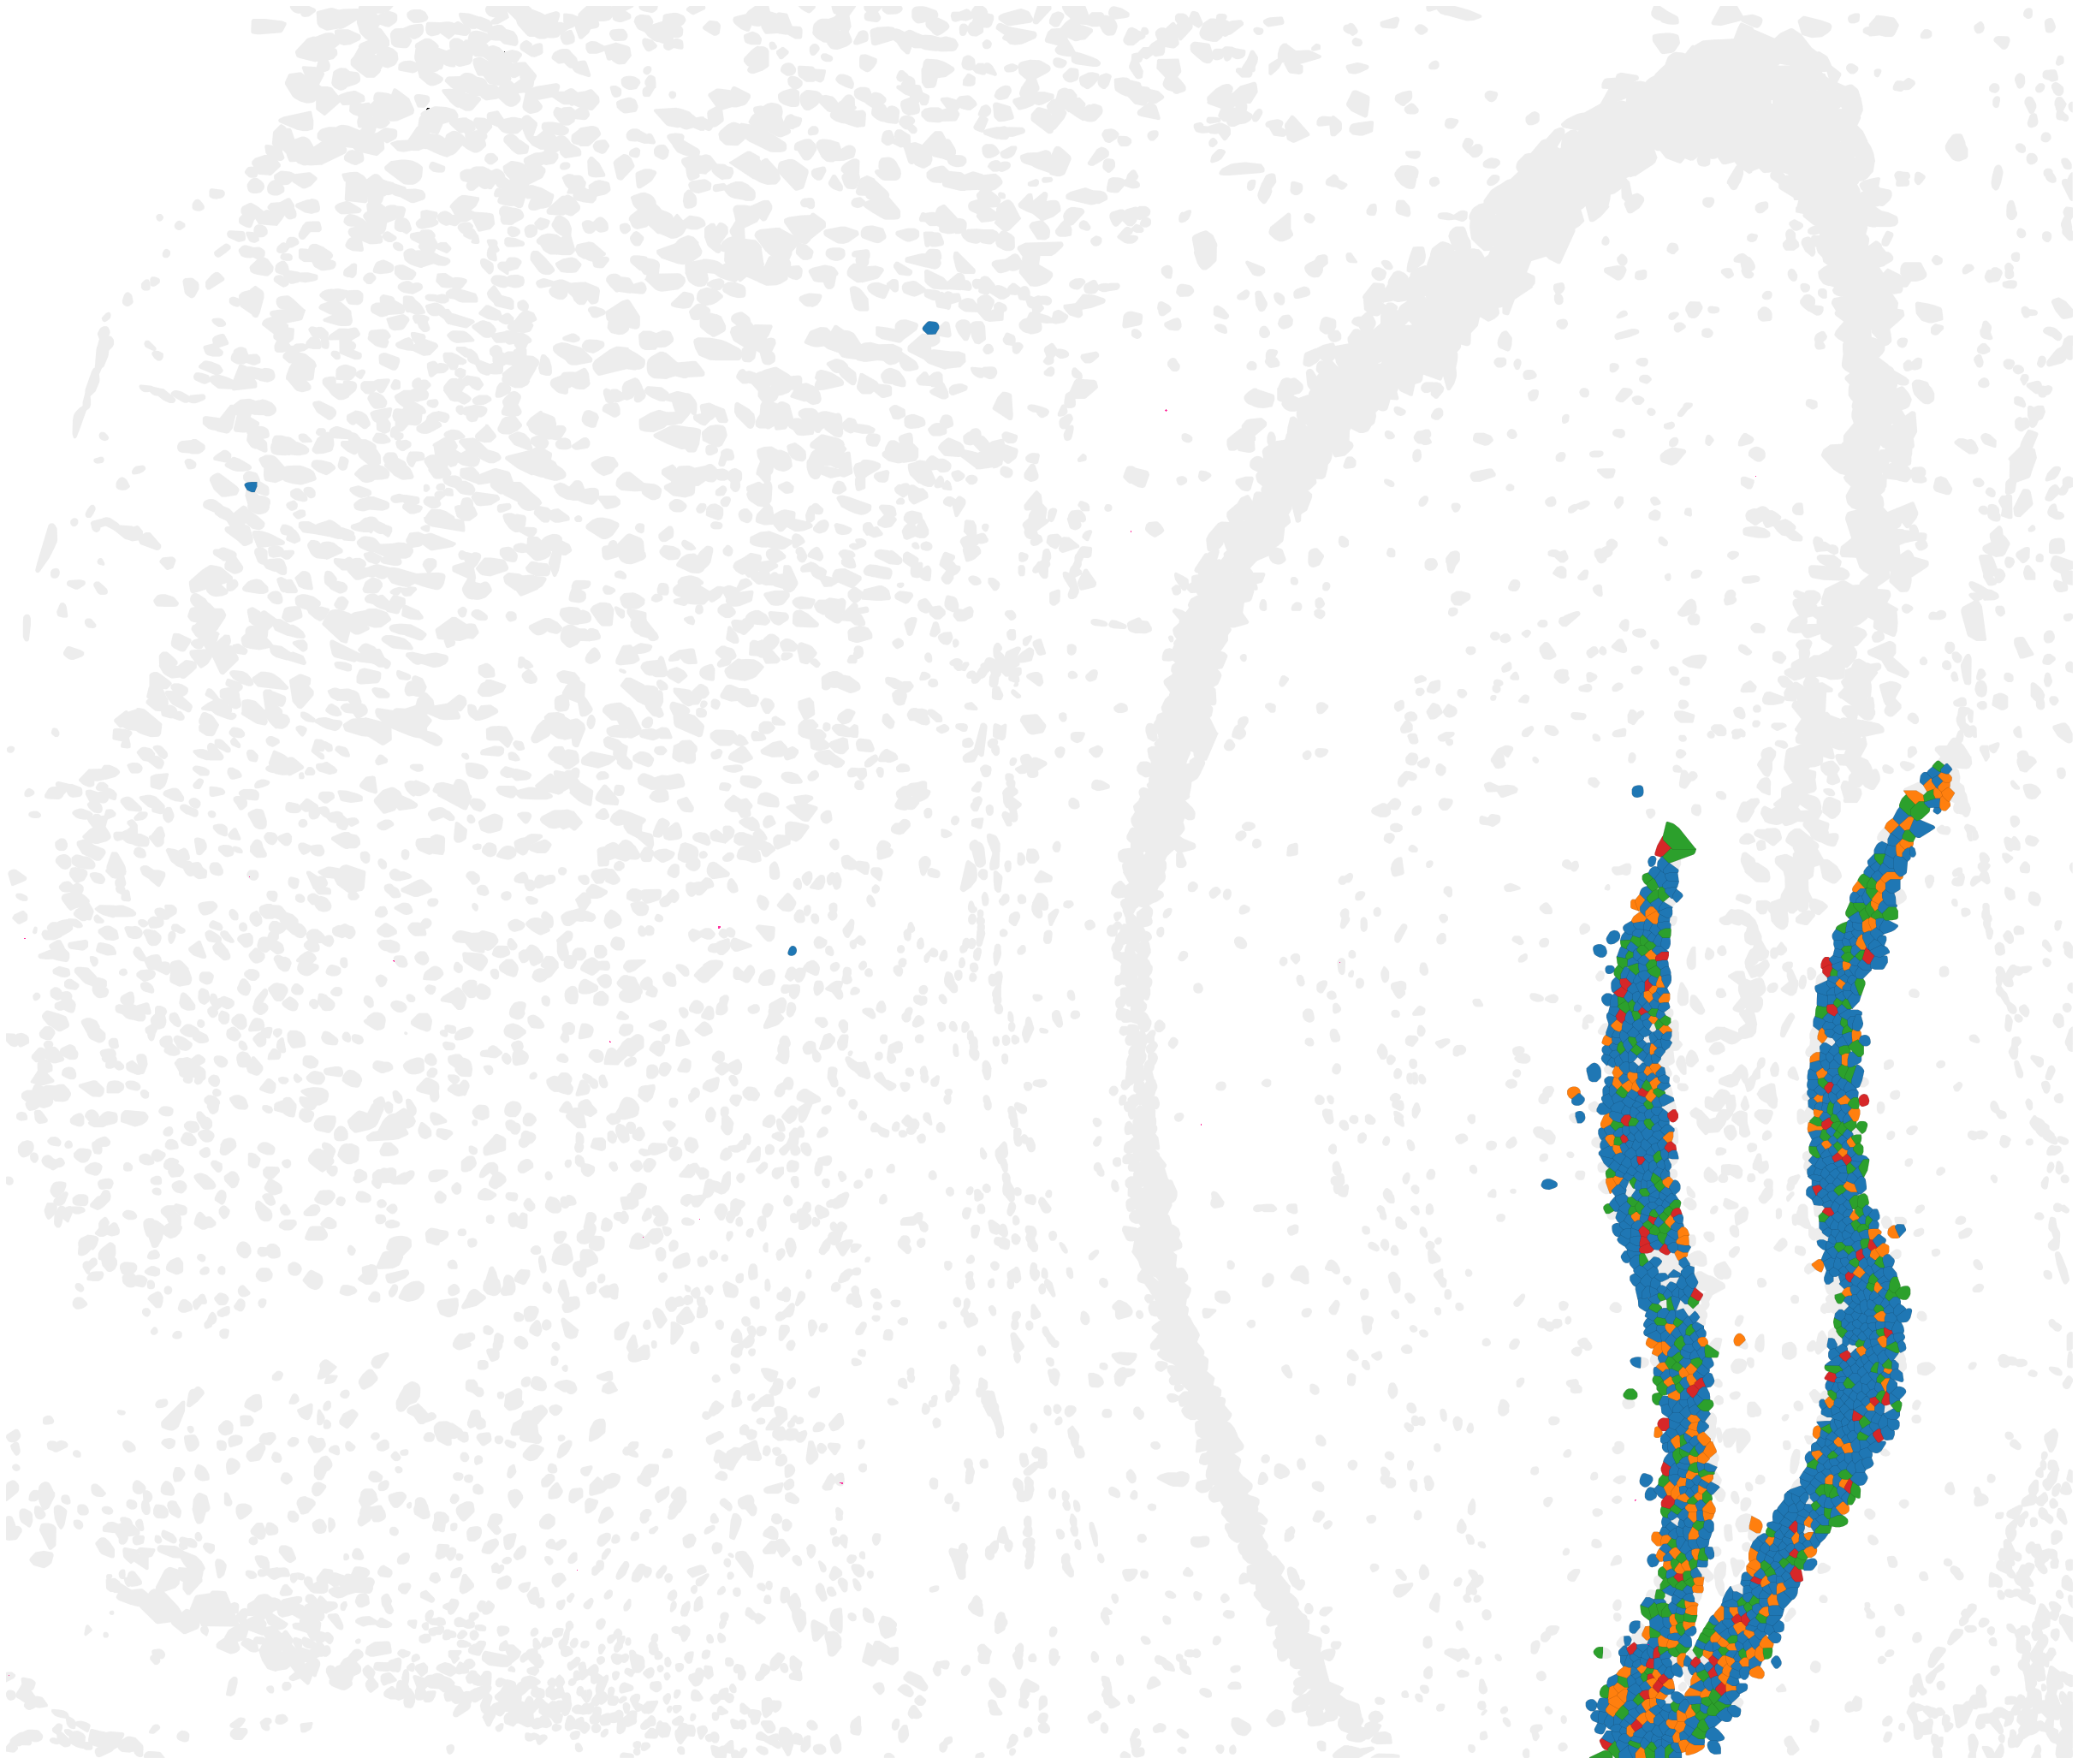

AD_mouse9723


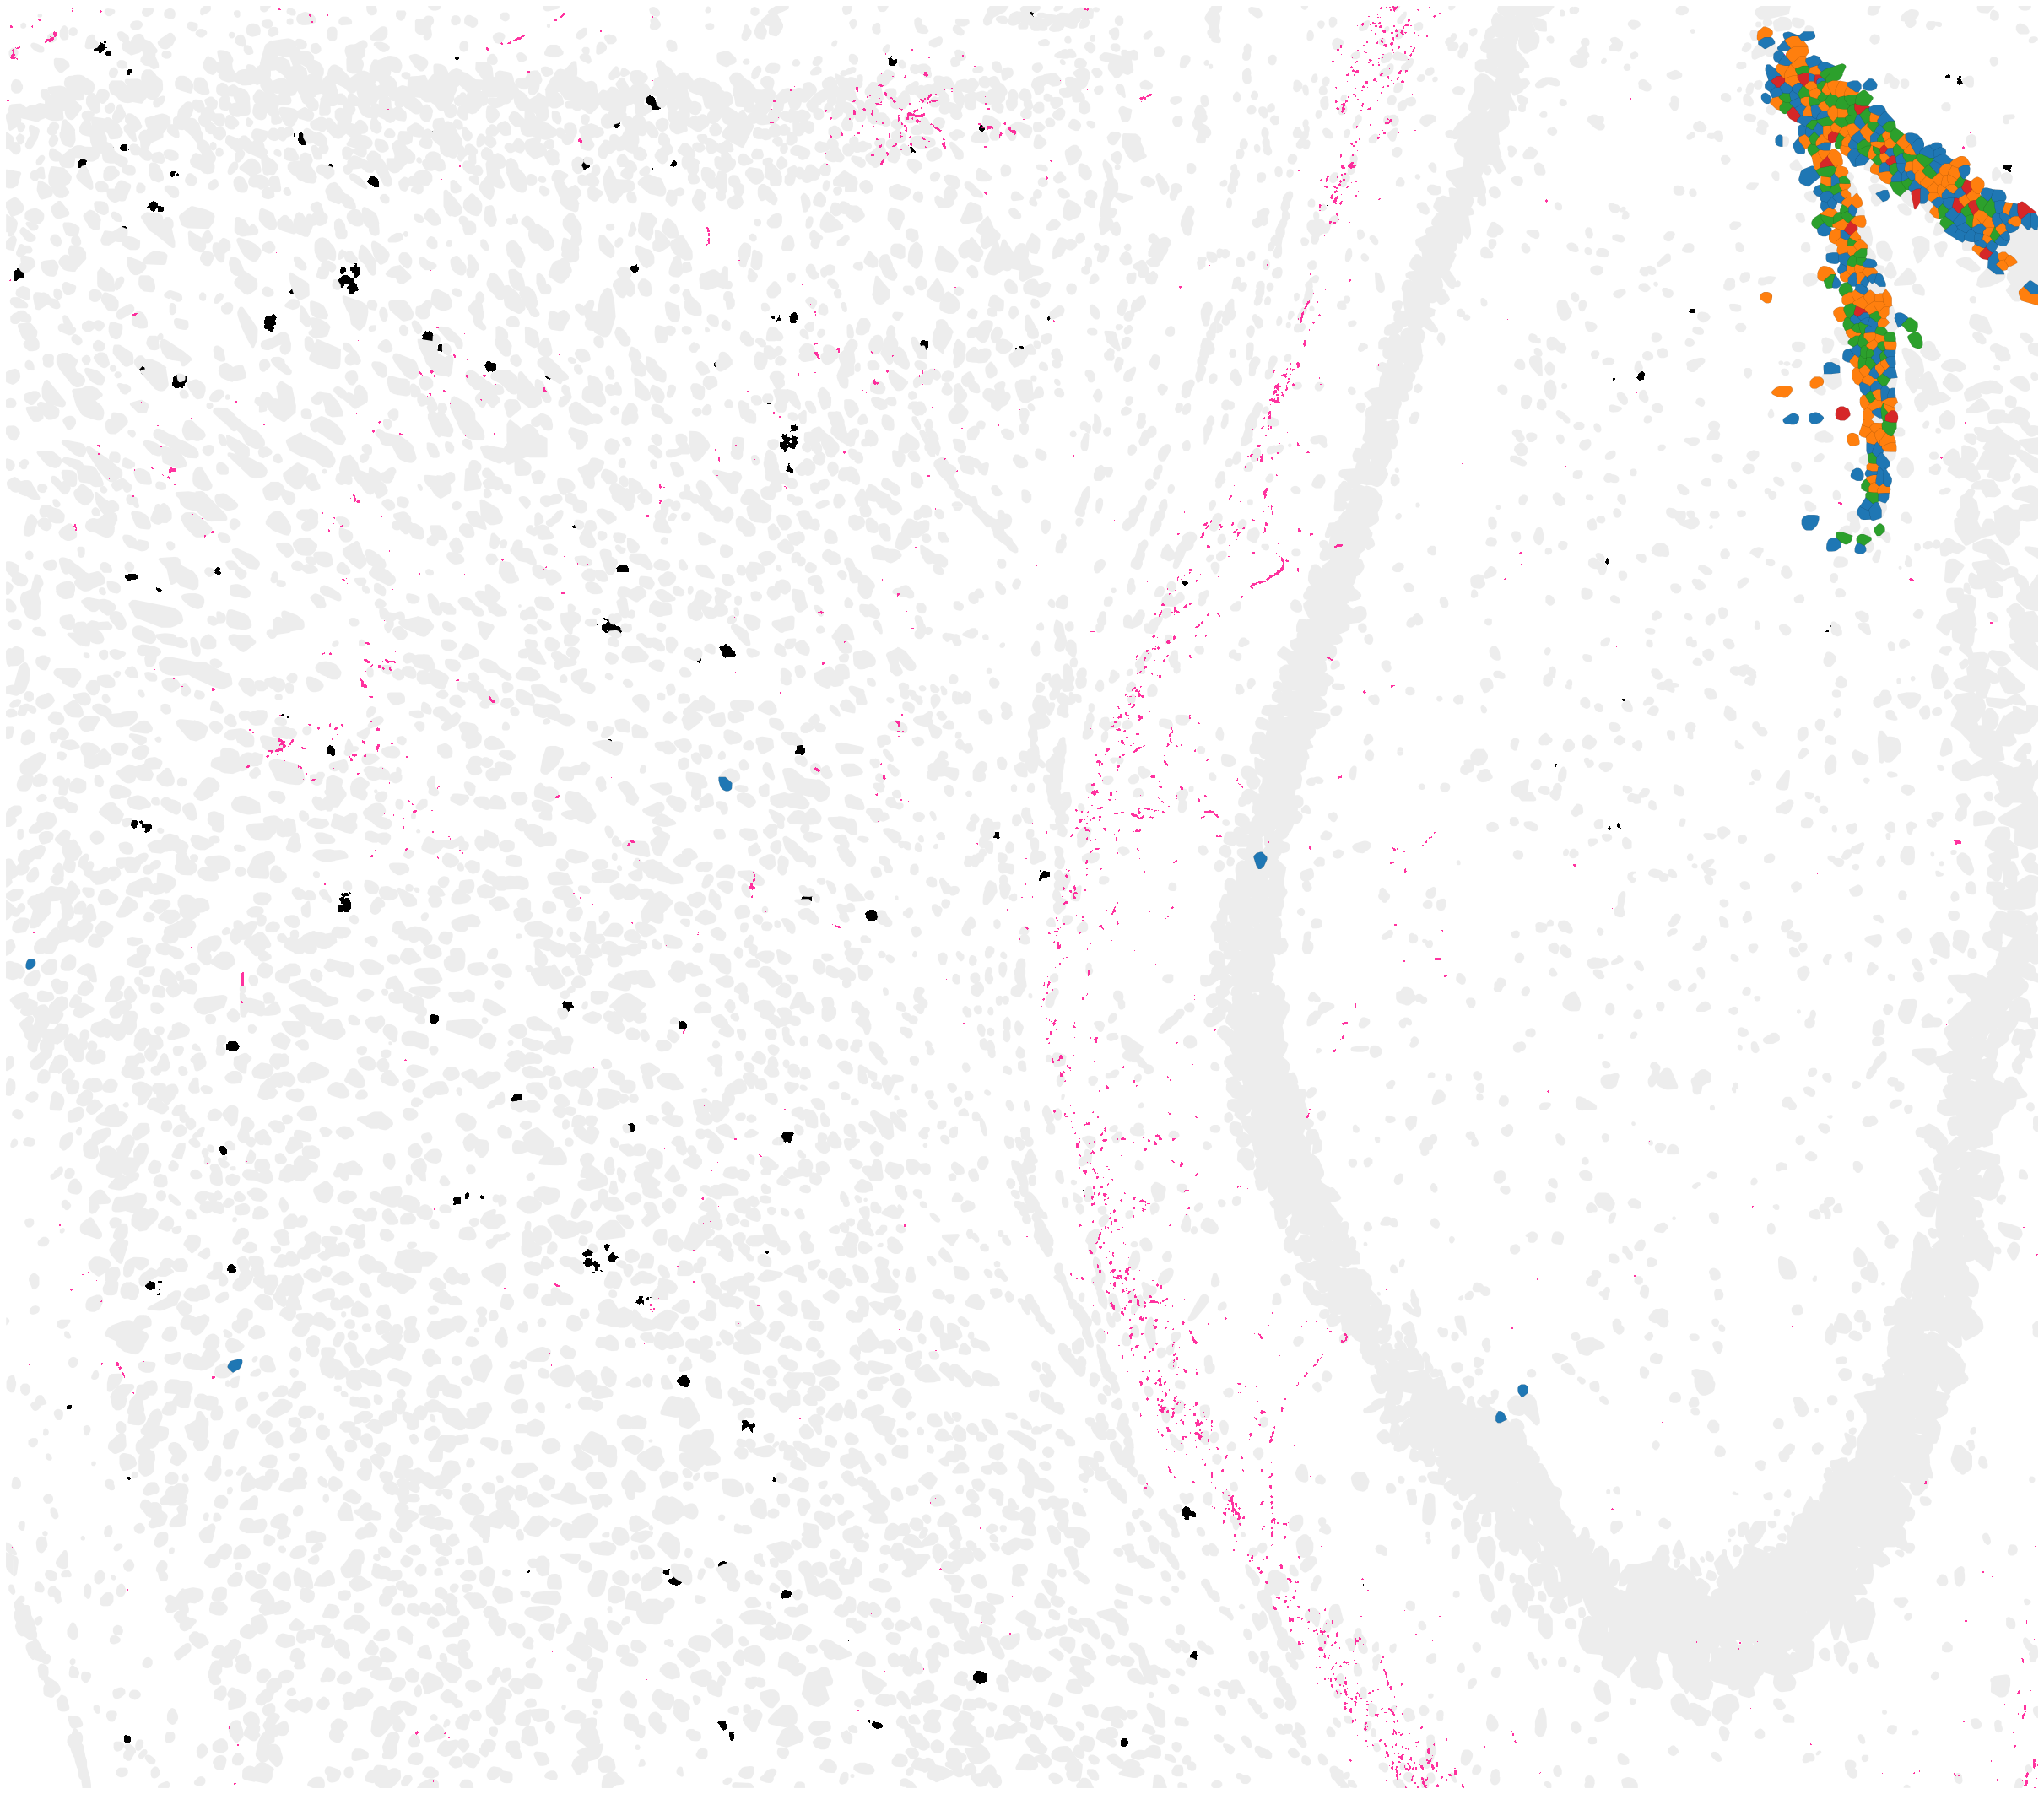

AD_mouse9735


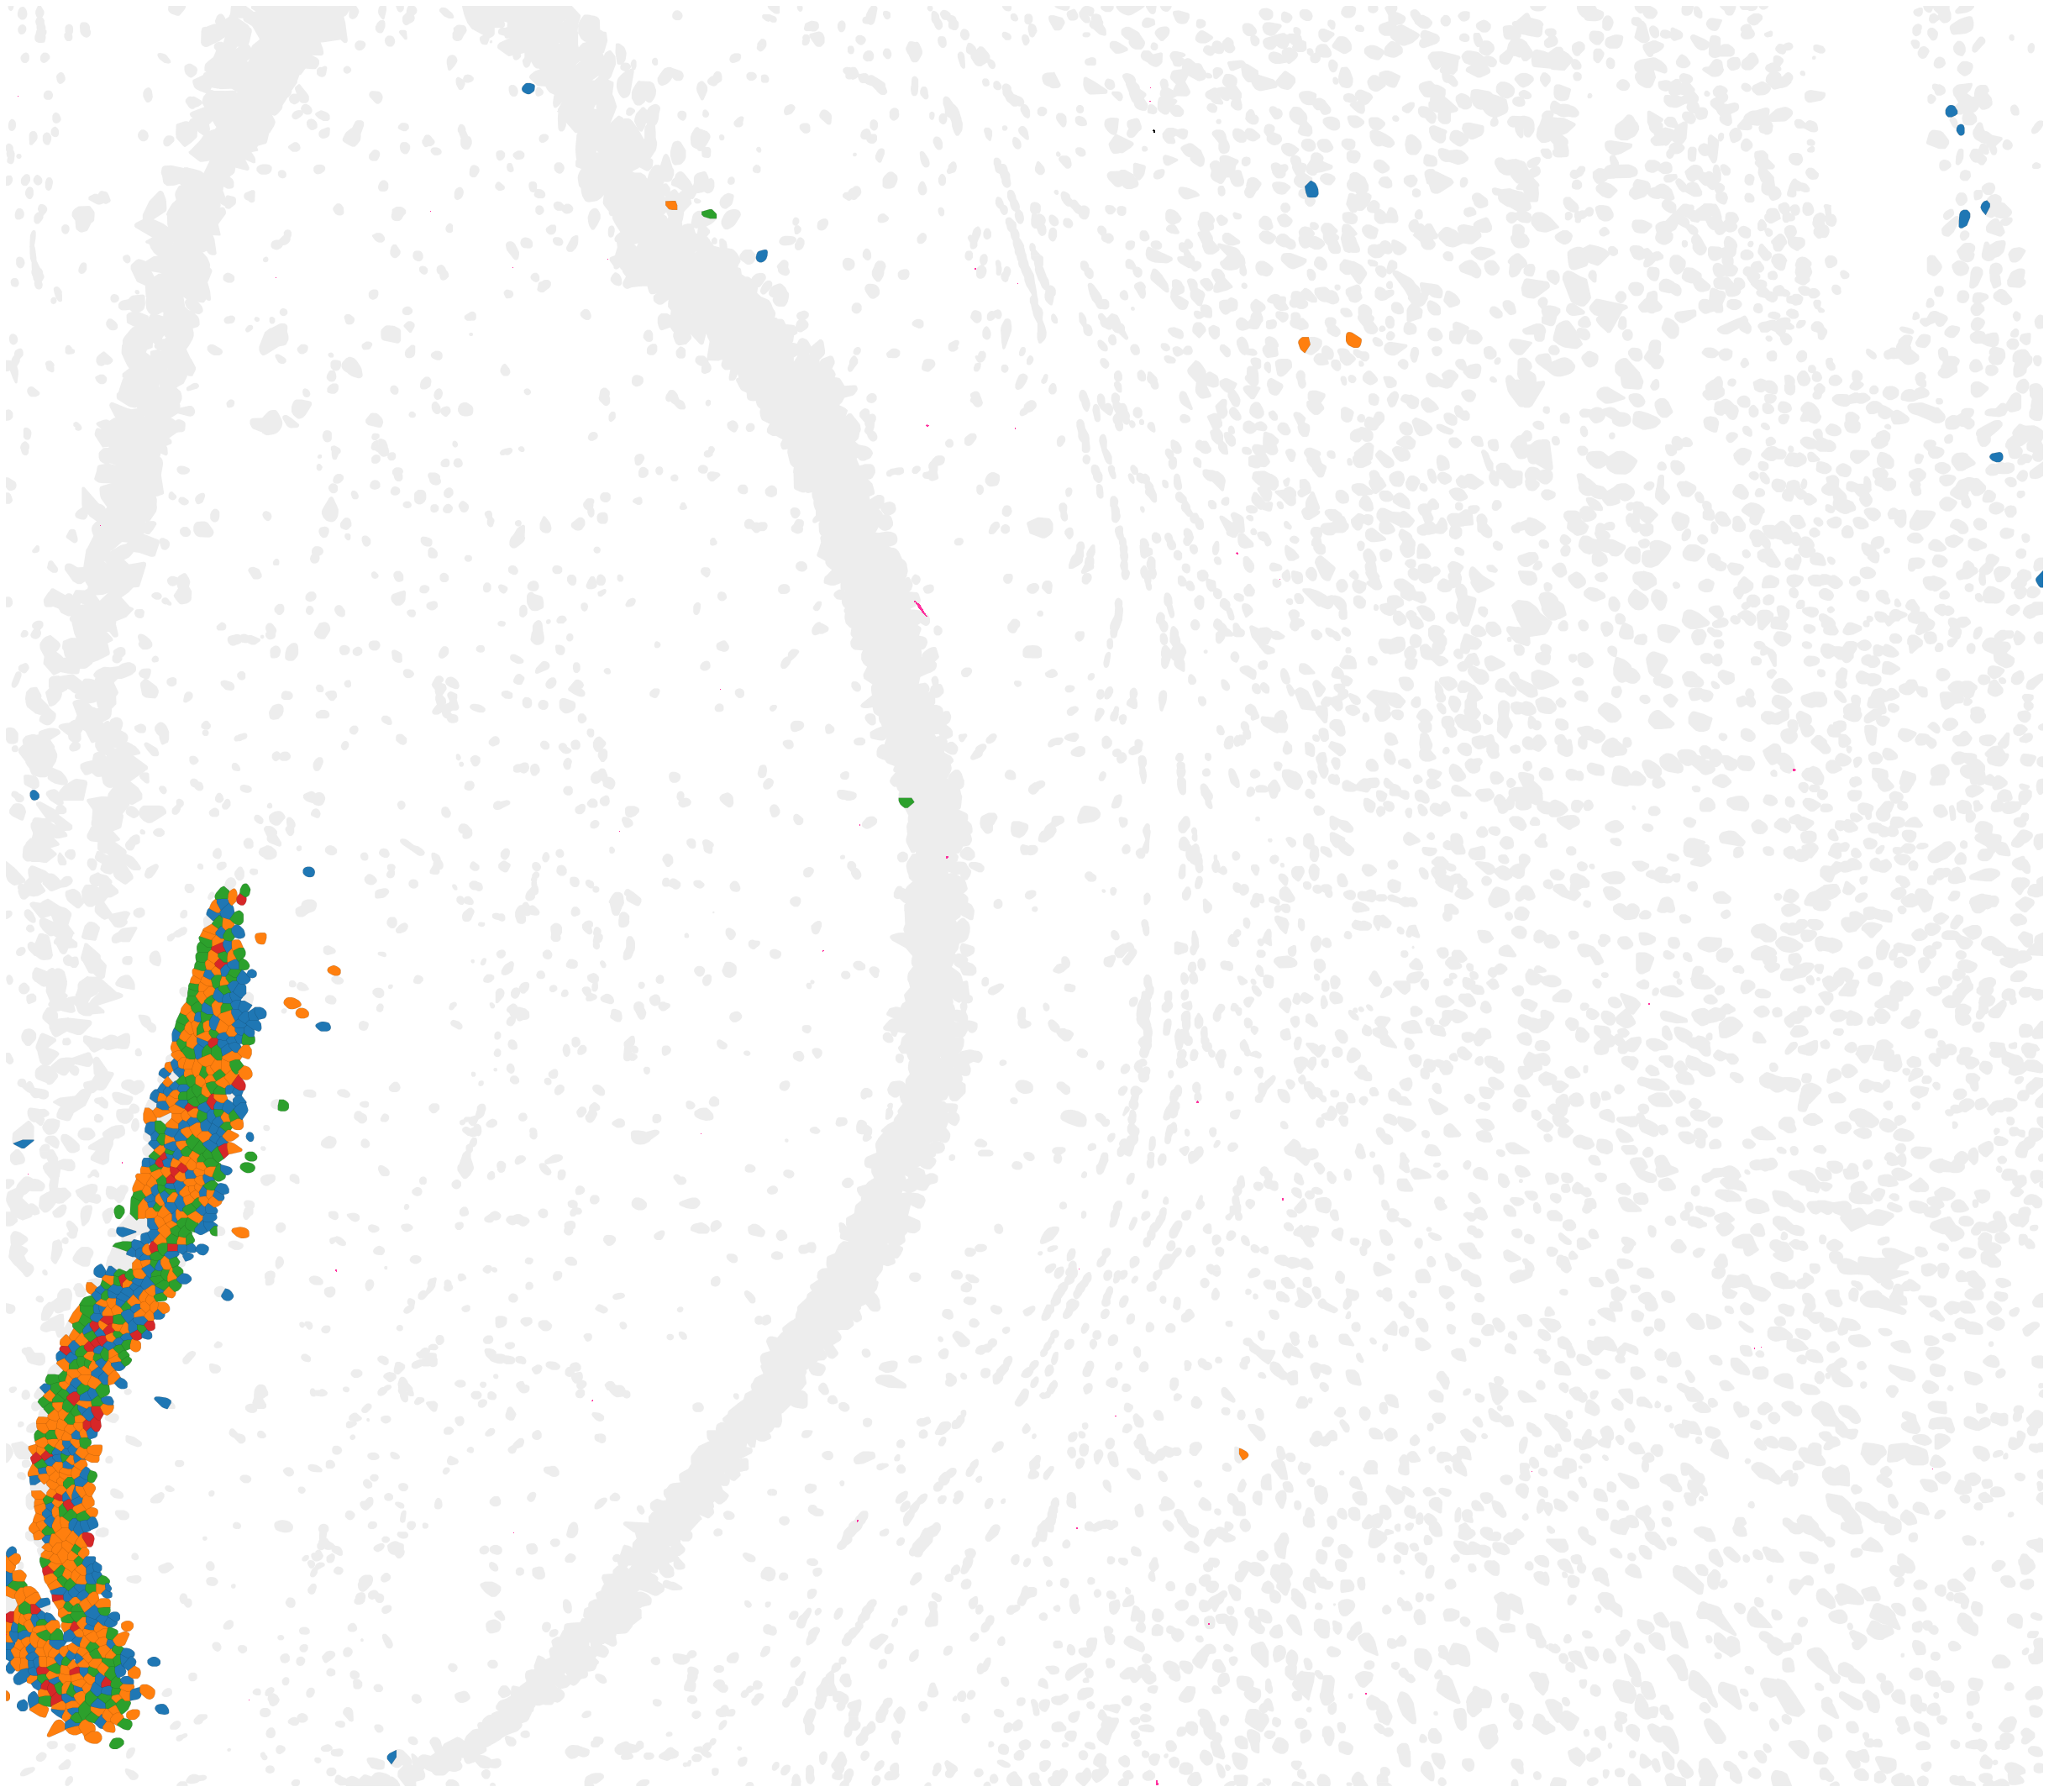

In [162]:
# Check current spatial cell type 
n_plots = 4
for i, sample in enumerate(sorted(sdata.obs['sample'].unique())[:n_plots]):
    print(sample)
    su.plot_poly_cells_cluster_by_sample(sdata, sample, cluster_cmap, show_plaque=True, show_tau=True,
                                        figscale=5, width=10, height=10)

### 2021-06-04

In [3]:
adata = sc.read_h5ad('./output/2021-04-22-starmap-mAD-raw.h5ad')
adata

AnnData object with n_obs × n_vars = 33106 × 2766
    obs: 'orig_index', 'sample', 'area', 'tau', 'x', 'y', 'batch', 'time', 'group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts', 'leiden', '__is_in_cluster__', 'top_level', 'cell_type', 'region', 'cell_type_label'
    var: 'max_counts', 'highly_variable'
    uns: 'AD_mouse9494_morph', 'AD_mouse9498_morph', 'AD_mouse9723_morph', 'AD_mouse9735_morph', 'cell_type_label', 'cell_type_order', 'label_hex_dict', 'label_rgb_dict', 'sub_hex_dict', 'sub_rgb_dict', 'top_hex_dict', 'top_level_order', 'top_rgb_dict'

In [4]:
# modify var dataframe 
var_df = pd.read_csv('./output/2021-06-02-var-bk.csv')
adata.var['detected'] = var_df['highly_variable'].values
adata.var = adata.var.drop(labels='highly_variable', axis=1)
adata.var['detected'].value_counts()

True     2112
False     654
Name: detected, dtype: int64

In [5]:
# check obs
obs_df = pd.read_csv('./output/2021-06-04-obs.csv', index_col=0)
obs_df = obs_df.drop(columns=['leiden', '__is_in_cluster__'])
obs_df.index = obs_df.index.astype(str)
adata.obs = obs_df
obs_df

orig_index        sample  area  tau     x     y    batch       time  \
2               2  AD_mouse9494  5732  0.0   905     5  batch_2  13_months   
8               8  AD_mouse9494  5739  0.0  2366     7  batch_2  13_months   
9               9  AD_mouse9494  8115  0.0   983     9  batch_2  13_months   
11             11  AD_mouse9494  5158  0.0  4057     9  batch_2  13_months   
13             13  AD_mouse9494  5765  0.0  3826     8  batch_2  13_months   
...           ...           ...   ...  ...   ...   ...      ...        ...   
37057        8229  AD_mouse9498  6805  0.0  4771  6697  batch_2  13_months   
37059        8231  AD_mouse9498  5826  0.0  1118  6699  batch_2  13_months   
37060        8232  AD_mouse9498  9964  0.0  5630  6697  batch_2  13_months   
37061        8233  AD_mouse9498  5248  0.0  5175  6699  batch_2  13_months   
37062        8234  AD_mouse9498  4200  0.0  3078  6697  batch_2  13_months   

         group  n_genes_by_counts  log1p_n_genes_by_counts  total_counts  \
2      disease                133                 4.897840         151.0   
8      disease                 90                 4.510860         111.0   
9      disease                187                 5.236442         227.0   
11     disease                 82                 4.418841         101.0   
13     disease                 90                 4.510860         112.0   
...        ...                ...                      ...           ...   
37057  control                 94                 4.553877         102.0   
37059  control                122                 4.812184         143.0   
37060  control                139                 4.941642         186.0   
37061  control                121                 4.804021         141.0   
37062  control                 73                 4.304065          93.0   

       log1p_total_counts  n_genes  n_counts top_level        cell_type  \
2                5.023880      133     144.0        DG               DG   
8                4.718499       90     107.0     Astro   Astro_Gfap/Vim   
9                5.429346      187     218.0        DG               DG   
11               4.624973       82      99.0       SMC           VLMC_A   
13               4.727388       90     109.0     Micro  Micro_Cst7/Ctsb   
...                   ...      ...       ...       ...              ...   
37057            4.634729       94      92.0       LHb              LHb   
37059            4.969813      122     140.0        Ex       L4/5_RSC_A   
37060            5.231109      139     177.0       LHb              LHb   
37061            4.955827      121     137.0      Inhi              Vip   
37062            4.543295       73      90.0     Oligo            Oligo   

            region cell_type_label  
2      Hippocampus              DG  
8      Hippocampus              A3  
9      Hippocampus              DG  
11     Hippocampus              S4  
13     Hippocampus              M3  
...            ...             ...  
37057  Hippocampus             LHb  
37059  Hippocampus         CTX-Ex2  
37060  Hippocampus             LHb  
37061  Hippocampus             In6  
37062  Hippocampus             OL1  

[33106 rows x 19 columns]

In [6]:
# set obs categories 

# sample 
adata.obs['sample'] = adata.obs['sample'].astype('category')
adata.obs['sample'] = adata.obs['sample'].cat.reorder_categories(['AD_mouse9735', 'AD_mouse9723', 'AD_mouse9498', 'AD_mouse9494'])

# batch 
adata.obs['batch'] = adata.obs['batch'].astype('category')
adata.obs['batch'] = adata.obs['batch'].cat.reorder_categories(['batch_1', 'batch_2'])

# time 
adata.obs['time'] = adata.obs['time'].astype('category')
adata.obs['time'] = adata.obs['time'].cat.reorder_categories(['8_months', '13_months'])

# group 
adata.obs['group'] = adata.obs['group'].astype('category')
adata.obs['group'] = adata.obs['group'].cat.reorder_categories(['control', 'disease'])

# region 
adata.obs['region'] = adata.obs['region'].replace({'White Matter': 'Corpus Callosum'})
adata.obs['region'] = adata.obs['region'].astype('category')
adata.obs['region'] = adata.obs['region'].cat.reorder_categories(['Cortex', 'Corpus Callosum', 'Hippocampus'])

# top-level
adata.obs['top_level'] = adata.obs['top_level'].replace({'Ex': 'CTX-Ex', 'Inhi': 'Inh'})
top_level_order = ['CTX-Ex', 'Inh', 'CA1', 'CA2', 'CA3', 'DG', 'Astro', 'Endo', 'Micro', 'Oligo', 'OPC', 'SMC', 'LHb']
adata.obs['top_level'] = adata.obs['top_level'].astype('category')
adata.obs['top_level'] = adata.obs['top_level'].cat.reorder_categories(top_level_order)

# cell_type
cell_type_order = ['L2/3', 'L4/5_RSC_A', 'L4/5_RSC_B', 'L6', # CTX-Ex
                           'Cnr1', 'Lamp5', 'Pvalb', 'Pvalb_Nog', 'Sst', 'Vip',
                           'CA1', 'CA2', 'CA3', 'DG', 
                            'Astro', 'Astro_Cst3', 'Astro_Gfap/Vim',
                           'Endo', 'Endo_Cldn5+', 'Endo_Esam+',
                           'Micro', 'Micro_Gpr34', 'Micro_Cst7/Ctsb',
                           'Oligo', 'Oligo_Klk6', 'Oligo_Cldn11',
                            'OPC', 'OPC_Gpr17',
                           'SMC', 'Peri_A', 'Peri_B', 'VLMC_A', 'VLMC_B',
                            'LHb']

adata.obs['cell_type'] = adata.obs['cell_type'].astype('category')
adata.obs['cell_type'] = adata.obs['cell_type'].cat.reorder_categories(cell_type_order)

# cell_type_label
adata.obs['cell_type_label'] = adata.obs['cell_type_label'].replace({'In1': 'Inh1', 'In2': 'Inh2', 'In3': 'Inh3', 'In4': 'Inh4', 'In5': 'Inh5', 'In6': 'Inh6',
                                                                'A1': 'Astro1', 'A2': 'Astro2', 'A3': 'Astro3',
                                                                'E1': 'Endo1', 'E2': 'Endo2', 'E3': 'Endo3',
                                                                'M1': 'Micro1', 'M2': 'Micro2', 'M3': 'Micro3',
                                                                'OL1': 'Oligo1', 'OL2': 'Oligo3', 'OL3': 'Oligo2'})
cell_type_label_order = ['CTX-Ex1', 'CTX-Ex2', 'CTX-Ex3', 'CTX-Ex4',
                           'Inh1', 'Inh2', 'Inh3', 'Inh4', 'Inh5', 'Inh6',
                           'CA1', 'CA2', 'CA3', 'DG', 
                            'Astro1', 'Astro2', 'Astro3',
                           'Endo1', 'Endo2', 'Endo3',
                           'Micro1', 'Micro2', 'Micro3',
                           'Oligo1', 'Oligo2', 'Oligo3',
                            'O1', 'O2',
                           'S1', 'S2', 'S3', 'S4', 'S5',
                            'LHb']

adata.obs['cell_type_label'] = adata.obs['cell_type_label'].astype('category')
adata.obs['cell_type_label'] = adata.obs['cell_type_label'].cat.reorder_categories(cell_type_label_order)

# update orders
adata.uns['top_level_order'] = top_level_order
adata.uns['cell_type_order'] = cell_type_order
del adata.uns['cell_type_label']
adata.uns['cell_type_label_order'] = cell_type_label_order

In [7]:
adata

AnnData object with n_obs × n_vars = 33106 × 2766
    obs: 'orig_index', 'sample', 'area', 'tau', 'x', 'y', 'batch', 'time', 'group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts', 'top_level', 'cell_type', 'region', 'cell_type_label'
    var: 'max_counts', 'detected'
    uns: 'AD_mouse9494_morph', 'AD_mouse9498_morph', 'AD_mouse9723_morph', 'AD_mouse9735_morph', 'cell_type_order', 'label_hex_dict', 'label_rgb_dict', 'sub_hex_dict', 'sub_rgb_dict', 'top_hex_dict', 'top_level_order', 'top_rgb_dict', 'cell_type_label_order'

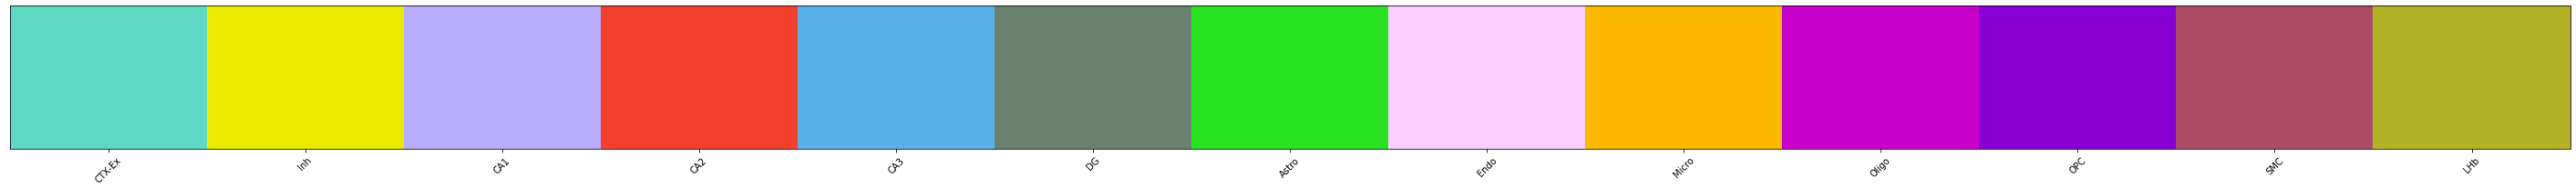

In [8]:
# set the colors 

# top_level
adata.uns['top_hex_dict'] = {}
adata.uns['top_rgb_dict'] = {}

top_hex_dict = {'CTX-Ex': '#5fd9c3', 
                'Inh': '#ebeb00', 
                'CA1': '#b8adff', 
                'CA2': '#f2402c', 
                'CA3': '#5bb0eb', 
                'DG': '#698270', 
                'Astro': '#29e322', 
                'Endo': '#f9cfff', 
                'Micro': '#fcb900', 
                'Oligo': '#c800cc', 
                'OPC': '#8600d4', 
                'SMC': '#ab4b66', 
                'LHb': '#b3b125'}
top_cpl = sns.color_palette(list(top_hex_dict.values()))
sns.palplot(top_cpl, size=3)
plt.xticks(range(len(top_level_order)), top_level_order, size=10, rotation=45)
plt.tight_layout()
plt.show()

adata.uns['top_rgb_dict'] = dict(zip(top_level_order, list(map(list, top_cpl))))
adata.uns['top_hex_dict'] = dict(zip(top_level_order, top_cpl.as_hex()))

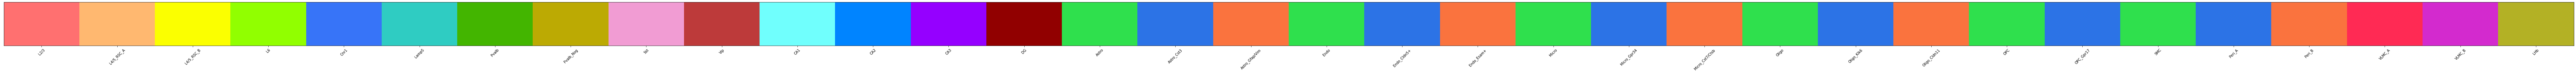

In [9]:
# cell_type
adata.uns['sub_hex_dict'] = {}
adata.uns['sub_rgb_dict'] = {}

sub_hex_dict = {'L2/3': '#ff7070', 
                'L4/5_RSC_A': '#ffb870', 
                'L4/5_RSC_B': '#fbff00', 
                'L6': '#91ff00', 
                'Cnr1': '#3774f8',
                'Lamp5': '#2fccc2', 
                'Pvalb': '#43b500', 
                'Pvalb_Nog': '#bcaa03', 
                'Sst': '#f19cd3', 
                'Vip': '#bd3a3a', 
                'CA1': '#70fffd', 
                'CA2': '#0084ff', 
                'CA3': '#9500ff', 
                'DG': '#910000', 
                'Astro': '#2fe04d',
                'Astro_Cst3': '#2c73e6', 
                'Astro_Gfap/Vim': '#fa733e', 
                'Endo': '#2fe04d', 
                'Endo_Cldn5+': '#2c73e6', 
                'Endo_Esam+': '#fa733e', 
                'Micro': '#2fe04d', 
                'Micro_Gpr34': '#2c73e6', 
                'Micro_Cst7/Ctsb': '#fa733e', 
                'Oligo': '#2fe04d', 
                'Oligo_Klk6': '#2c73e6', 
                'Oligo_Cldn11': '#fa733e', 
                'OPC': '#2fe04d', 
                'OPC_Gpr17': '#2c73e6', 
                'SMC': '#2fe04d', 
                'Peri_A': '#2c73e6', 
                'Peri_B': '#fa733e', 
                'VLMC_A': '#ff2a54', 
                'VLMC_B': '#d32ace',
                'LHb': '#b3b125'}
sub_cpl = sns.color_palette(list(sub_hex_dict.values()))
sns.palplot(sub_cpl, size=3)
plt.xticks(range(len(cell_type_order)), cell_type_order, size=10, rotation=45)
plt.tight_layout()
plt.show()

adata.uns['sub_rgb_dict'] = dict(zip(cell_type_order, list(map(list, sub_cpl))))
adata.uns['sub_hex_dict'] = dict(zip(cell_type_order, sub_cpl.as_hex()))

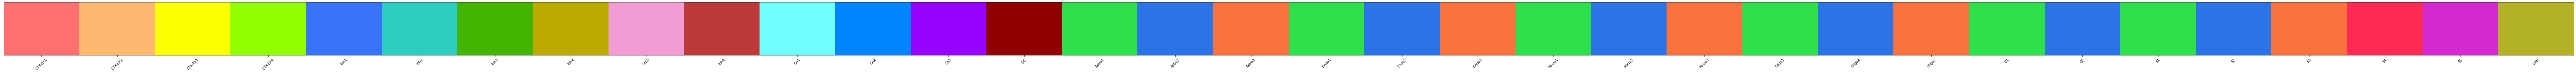

In [10]:
# cell_type_label
adata.uns['label_hex_dict'] = {}
adata.uns['label_rgb_dict'] = {}

label_hex_dict = {'CTX-Ex1': '#ff7070', 
                'CTX-Ex2': '#ffb870', 
                'CTX-Ex3': '#fbff00', 
                'CTX-Ex4': '#91ff00', 
                'Inh1': '#3774f8',
                'Inh2': '#2fccc2', 
                'Inh3': '#43b500', 
                'Inh4': '#bcaa03', 
                'Inh5': '#f19cd3', 
                'Inh6': '#bd3a3a', 
                'CA1': '#70fffd', 
                'CA2': '#0084ff', 
                'CA3': '#9500ff', 
                'DG': '#910000', 
                'Astro1': '#2fe04d',
                'Astro2': '#2c73e6', 
                'Astro3': '#fa733e', 
                'Endo1': '#2fe04d', 
                'Endo2': '#2c73e6', 
                'Endo3': '#fa733e', 
                'Micro1': '#2fe04d', 
                'Micro2': '#2c73e6', 
                'Micro3': '#fa733e', 
                'Oligo1': '#2fe04d', 
                'Oligo2': '#2c73e6', 
                'Oligo3': '#fa733e', 
                'O1': '#2fe04d', 
                'O2': '#2c73e6', 
                'S1': '#2fe04d', 
                'S2': '#2c73e6', 
                'S3': '#fa733e', 
                'S4': '#ff2a54', 
                'S5': '#d32ace',
                'LHb': '#b3b125'}
label_cpl = sns.color_palette(list(label_hex_dict.values()))
sns.palplot(label_cpl, size=3)
plt.xticks(range(len(cell_type_label_order)), cell_type_label_order, size=10, rotation=45)
plt.tight_layout()
plt.show()

adata.uns['label_rgb_dict'] = dict(zip(cell_type_label_order, list(map(list, label_cpl))))
adata.uns['label_hex_dict'] = dict(zip(cell_type_label_order, label_cpl.as_hex()))

In [11]:
# Load data and store the information to uns
for sample in sorted(adata.obs['sample'].unique()):
    print(sample)
    
    # Segmentation
    current_seg_path = os.path.join(sample, 'scaled/labeled_cells.tif')
    current_img = tifffile.imread(current_seg_path)
    
    # Plaque
    current_plaque_path = os.path.join(sample, 'scaled/plaque.tif')
    current_plaque = tifffile.imread(current_plaque_path)
    current_plaque = gaussian(current_plaque.astype(np.float), 2) > 30
    
    # Tau
    current_tau_path = os.path.join(sample, 'scaled/tau_mask.tif')
    current_tau = tifffile.imread(current_tau_path)
        
    # Region
    current_region_path = os.path.join(sample, 'scaled/bill-labels.tif')
    current_region_img = tifffile.imread(current_region_path)

    # Morph
    current_key = f"{sample}_morph"
    adata.uns[current_key] = {}
    adata.uns[current_key]['label_img'] = current_img
    adata.uns[current_key]['plaque'] = current_plaque
    adata.uns[current_key]['tau'] = current_tau
    adata.uns[current_key]['region'] = current_region_img

AD_mouse9494
AD_mouse9498
AD_mouse9723
AD_mouse9735


In [12]:
adata

AnnData object with n_obs × n_vars = 33106 × 2766
    obs: 'orig_index', 'sample', 'area', 'tau', 'x', 'y', 'batch', 'time', 'group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts', 'top_level', 'cell_type', 'region', 'cell_type_label'
    var: 'max_counts', 'detected'
    uns: 'AD_mouse9494_morph', 'AD_mouse9498_morph', 'AD_mouse9723_morph', 'AD_mouse9735_morph', 'cell_type_order', 'label_hex_dict', 'label_rgb_dict', 'sub_hex_dict', 'sub_rgb_dict', 'top_hex_dict', 'top_level_order', 'top_rgb_dict', 'cell_type_label_order'

In [13]:
# save raw
adata.write_h5ad('./output/2021-06-04-starmap-mAD-raw.h5ad')

In [14]:
# normalization and scale 
# Normalization scaling
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

adata.raw = adata

# Scale data to unit variance and zero mean
sc.pp.scale(adata)
adata.layers['scaled'] = adata.X

# Batch correction
sc.pp.combat(adata)
adata.layers['corrected'] = adata.X

In [15]:
# save scale
adata.write_h5ad('./output/2021-06-04-starmap-mAD-scaled.h5ad')